# Lab 3 Reduction and Analysis

# Imports

In [1]:
# imports 
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import median_filter

# %matplotlib widget  

# Filepaths

In [2]:
# define directories with data
base_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3'
data_dir = os.path.join(base_dir, 'data')
wl_cals_dir = os.path.join(data_dir, 'wl_cals')
solar_dir = os.path.join(data_dir, 'solar')
master_cals_dir = os.path.join(data_dir, 'master_cals')

# master calibration data filepaths
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

# calibration data filepaths
he_cal_fname = os.path.join(wl_cals_dir, 'he_cal_1-5s_exp4.fit')
ne_ar_init_fname = os.path.join(wl_cals_dir, 'ne_ar_cal_15s_exp3.fit')

# solar spectrum data
solar_1 = os.path.join(solar_dir, 'twilight_200s_exp1.fit')
solar_2 = os.path.join(solar_dir, 'twilight_400s_exp2.fit')

# Important Lines/Series:

In [3]:
balmer = [6562.8, 4861.33, 4340.47, 4101.74, 3970.07, 3889.05, 3835.38]
wavelengths_He = np.array([3880,4470,5010,5880,6680,7060,7280])
fraunhofer = np.array([3934, 3968, 4308, 4861, 5270, 5890, 5896, 6563, 6875.5, 7607.5])

# Functions

In [4]:
# Functions from Dillon's pipeline

def load_image(fname):
    """Read FITS image and return numpy array + header."""
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)   # 30s dark
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub / safe_flat
    return sci_calibrated, hdr

def crop_spectrum_region(image, center_row=3100, height=100, plots=True):
    half = height // 2
    y_min = max(center_row - half, 0)
    y_max = min(center_row + half, image.shape[0])
    crop = image[y_min:y_max, :]
    plt.figure(figsize=(10,4))
    plt.imshow(crop, cmap="viridis", norm=LogNorm(), origin="lower")
    return crop

def plot_spectral_profile(cropped_image):
    spectrum = np.sum(cropped_image, axis=0)
    xpix = np.arange(len(spectrum))

    plt.figure(figsize=(12, 4))
    plt.plot(xpix, spectrum, color='black', linewidth=1)
    plt.xlim([3000, 8000])
    plt.xlabel("Pixel index")
    plt.ylabel("Integrated counts")
    plt.title("Extracted 1D Spectral Profile")
    plt.tight_layout()
    plt.show()

    return spectrum

def detect_trace_center(crop):
    row_sums = np.sum(crop, axis=1)
    y = np.arange(len(row_sums))

    def gauss(x, A, mu, sigma, C):
        return A * np.exp(-(x - mu)**2/(2*sigma**2)) + C

    A0 = row_sums.max() - row_sums.min()
    mu0 = np.argmax(row_sums)
    sigma0 = 5
    C0 = row_sums.min()

    popt, _ = curve_fit(gauss, y, row_sums, p0=[A0, mu0, sigma0, C0])
    mu, sigma = popt[1], abs(popt[2])

    plt.figure(figsize=(10,4))
    plt.imshow(crop, cmap="viridis", norm=LogNorm(), origin="lower")
    plt.axhline(mu, alpha=.7, color="red", linestyle="--", linewidth=2)
    plt.show()

    return mu, sigma

def isolate_spectrum(crop, y_trace, sigma):
    ny, nx = crop.shape
    # tune these values if you want
    signal_sigma = 2.8
    bg_min_sigma = signal_sigma + 1
    bg_max_sigma = bg_min_sigma + signal_sigma
    y1 = int(max(0, y_trace - signal_sigma*sigma))
    y2 = int(min(ny, y_trace + signal_sigma*sigma))
    b1s = int(max(0, y_trace - bg_max_sigma*sigma))
    b1e = int(max(0, y_trace - bg_min_sigma*sigma))
    b2s = int(min(ny, y_trace + bg_min_sigma*sigma))
    b2e = int(min(ny, y_trace + bg_max_sigma*sigma))

    sky = []
    if b1e > b1s: sky.append(crop[b1s:b1e, :])
    if b2e > b2s: sky.append(crop[b2s:b2e, :])
    sky = np.concatenate(sky, axis=0)

    sky_level = np.median(sky, axis=0)

    spec = crop[y1:y2, :] - sky_level

    return spec


def inspect_trace_fit(spec_strip, mu, sigma):
    row_sums = np.sum(spec_strip, axis=1)
    y = np.arange(len(row_sums))

    A = row_sums.max()
    C = np.median(row_sums)
    gauss = A * np.exp(-(y - mu)**2 / (2*sigma**2)) + C

    signal_sigma = 2.8
    bg_min_sigma = signal_sigma + 1
    bg_max_sigma = bg_min_sigma + signal_sigma

    
    plt.figure(figsize=(12,4))
    plt.axvspan(mu - signal_sigma*sigma, mu + signal_sigma*sigma, color='lightgreen', alpha=0.4)

    plt.axvspan(mu - bg_max_sigma*sigma, mu - bg_min_sigma*sigma, color='orange', alpha=0.4)
    plt.axvspan(mu + bg_min_sigma*sigma, mu + bg_max_sigma*sigma, color='orange', alpha=0.4)

    plt.plot(y, row_sums, 'k-', lw=1)
    plt.plot(y, gauss, 'r--', lw=2)

    plt.xlabel("Row index in spec_strip")
    plt.ylabel("Sum of counts")
    plt.title(f"Trace Gaussian Fit: mu={mu:.2f}, sigma={sigma:.2f}")
    plt.tight_layout()
    plt.show()

def find_and_plot_peaks(spectrum, n=8, reference_pixels=None):
    spec = spectrum.astype(float)
    smooth = gaussian_filter1d(spec, sigma=2)
    peaks, props = find_peaks(
        smooth,
        prominence=0.05*np.max(smooth),
        width=2,               
        distance=20)

    if len(peaks) < n:
        peaks, props = find_peaks(
            smooth,
            prominence=0.03*np.max(smooth),
            width=1,
            distance=10)

    heights = smooth[peaks]
    order = np.argsort(heights)[::-1]
    top = peaks[order[:n]]

    top = np.sort(top)

    plt.figure(figsize=(12,4))
    plt.plot(spec, 'gray', lw=1, alpha=0.5)
    plt.plot(smooth, 'k-', lw=1)
    for p in top:
        plt.axvline(p, color='blue', alpha=0.4)
    if reference_pixels is not None:
        for r in reference_pixels:
            plt.axvline(r, color='red', linestyle='--', alpha=0.6)

    plt.xlabel("Pixel index")
    plt.ylabel("Counts")
    plt.title("Peak Detection")
    plt.tight_layout()
    plt.show()

    return top.tolist()

def fit_linear_wavelength(lines_pix, lines_ref):
    pix = np.array(lines_pix, dtype=float)
    lam = np.array(lines_ref, dtype=float)
    a, b = np.polyfit(pix, lam, 1)
    lam_fit = a * pix + b
    ss_res = np.sum((lam - lam_fit)**2)
    ss_tot = np.sum((lam - np.mean(lam))**2)
    r2 = 1 - ss_res/ss_tot

    plt.figure(figsize=(7,5))
    plt.scatter(pix, lam, color='blue', label='He line matches')
    
    xline = np.linspace(min(pix), max(pix), 200)
    yline = a * xline + b
    plt.plot(xline, yline, 'r-', label=f'Fit: λ = {a:.4f}·p + {b:.2f}')

    plt.xlabel("Pixel position")
    plt.ylabel("Wavelength (Å)")
    plt.title(f"Linear Wavelength Fit   (R² = {r2:.5f})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return a, b, r2

def apply_linear_wavesolution(spectrum, a, b, shift=0):
    n = len(spectrum)
    pixels = np.arange(n, dtype=float)
    wavelengths = a*(pixels+shift) + b
    return wavelengths

def plot_spectrum_with_refs(wavelengths, spectrum, reference_wavelengths=None, xlims=[0,11000]):
    plt.figure(figsize=(12,4))
    plt.plot(wavelengths, spectrum, 'k-', lw=1)

    if reference_wavelengths is not None:
        for w in reference_wavelengths:
            plt.axvline(w, color='red', linestyle='--', alpha=0.6)
    plt.xlim(xlims)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Counts")
    plt.title("Spectrum with Reference Lines")
    plt.tight_layout()
    plt.show()

def measure_pixel_shift(ref_spec, new_spec, max_shift=200):
    r = ref_spec - np.median(ref_spec)
    s = new_spec - np.median(new_spec)

    corr = correlate(s, r, mode='full')
    lags = np.arange(-len(s)+1, len(r))

    mask = (lags >= -max_shift) & (lags <= max_shift)
    corr = corr[mask]
    lags = lags[mask]

    best_lag = lags[np.argmax(corr)]
    return best_lag

import numpy as np
from scipy.signal import correlate

def measure_subpixel_shift(ref, new, max_shift=200):
    r = ref - np.median(ref)
    s = new - np.median(new)

    corr = correlate(s, r, mode='full')
    lags = np.arange(-len(s)+1, len(r))

    mask = (lags >= -max_shift) & (lags <= max_shift)
    corr = corr[mask]
    lags = lags[mask]
    k = np.argmax(corr)
    peak_lag = lags[k]

    if 0 < k < len(corr)-1:
        Ckm1 = corr[k-1]
        Ck   = corr[k]
        Ckp1 = corr[k+1]

        denom = (Ckm1 - 2*Ck + Ckp1)
        if denom != 0:
            delta = 0.5 * (Ckm1 - Ckp1) / denom
        else:
            delta = 0.0
    else:
        delta = 0.0

    return peak_lag + delta

def crop_spectrum(wave, flux, wmin, wmax):
    mask = (wave >= wmin) & (wave <= wmax)
    return wave[mask], flux[mask]

def flatten_with_median(wave, flux, width=301):
    cont = median_filter(flux, size=width)
    flat = flux / cont

    plt.figure(figsize=(12,4))
    plt.plot(wave, flux, 'k-', lw=1)
    plt.plot(wave, cont, 'r-', lw=2)
    plt.title("Median-Filter Continuum")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(wave, flat, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.title("Flattened Spectrum (Median)")
    plt.tight_layout()
    plt.show()

    return wave, flat, cont

def flatten_spectrum(wave, flux, deg=5):
    mask = np.isfinite(wave) & np.isfinite(flux) & (flux > 0)
    w = wave[mask]
    f = flux[mask]

    coeffs = np.polyfit(w, f, deg)
    cont = np.polyval(coeffs, w)

    flat = f / cont

    plt.figure(figsize=(12,4))
    plt.plot(w, f, 'k-', lw=1)
    plt.plot(w, cont, 'r-', lw=2)
    plt.title("Continuum Fit")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(w, flat, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.title("Flattened Spectrum")
    plt.tight_layout()
    plt.show()

    return w, flat, coeffs

def flatten_spectra(wl, spec, smooth_width=101, poly_deg=5):

    spec_smooth = median_filter(spec, smooth_width)
    ratio = spec / spec_smooth

    mask = (ratio > 0.99) & (wl > 4000) & (wl < 8000)
    wl_masked = wl[mask]
    spec_masked = spec[mask]

    coeffs = np.polyfit(wl_masked, spec_masked, poly_deg)
    continuum_fit = np.polyval(coeffs, wl)
    spec_normed = spec / continuum_fit

    plt.figure(figsize=(12,4))
    plt.plot(wl, ratio, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.xlim(4000, 8000)
    plt.title("Spectrum / Median Smooth")
    plt.tight_layout()
    plt.ylim([.9, 1.1])
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(wl, spec, 'gray', lw=1, label='Original Spectrum')
    plt.plot(wl_masked, spec_masked, 'b.', alpha=0.4, label='Continuum Points')
    plt.plot(wl, continuum_fit, 'r-', lw=2, label='Polynomial Fit')
    plt.xlim(4000, 8000)
    plt.ylim(0, np.nanmax(spec_masked)*1.1)
    plt.title("Continuum Fit")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(wl, spec_normed, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.xlim(4000, 8000)
    plt.ylim(0, 1.1)
    plt.title("Normalized Spectrum")
    plt.tight_layout()
    plt.show()

    return wl, spec_normed, continuum_fit

In [5]:
# My functions
def linear_fit(x, y):
    """
    Perform an analytical solution to fit y = mx + b.

    Parameters:
    x (array-like): Independent variable.
    y (array-like): Dependent variable.

    Returns:
    tuple: Slope (m) and intercept (b).
    """
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)

    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n

    return m, b


def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset


def measure_resolution(pixels,flux,dispersion_ang_per_pix,lambda_line,line_center_guess,fit_half_width_pix=10,):
    """
    Measure spectral resolution from an isolated line.

    Parameters
    ----------
    pixels : 1D array
        Pixel coordinate array (e.g. np.arange(n_pix)).
    flux : 1D array
        Flux values for the 1D extracted spectrum.
    dispersion_ang_per_pix : float
        Dispersion in Angstroms per pixel.
    lambda_line : float
        Wavelength (Angstrom) of the line you're fitting.
    line_center_guess : float
        Initial guess for the line center in PIXELS
        (e.g. np.argmax(flux) near the line).
    fit_half_width_pix : int, optional
        Half-width (in pixels) of the fitting window around line_center_guess.

    Returns
    -------
    results : dict
        {
            "mu_pix": line center in pixels,
            "sigma_pix": sigma of Gaussian in pixels,
            "fwhm_pix": FWHM in pixels,
            "fwhm_ang": FWHM in Angstroms,
            "R": resolving power at lambda_line
        }
    """
    # Select a window around the line
    mask = (
        (pixels >= line_center_guess - fit_half_width_pix)
        & (pixels <= line_center_guess + fit_half_width_pix)
    )
    x = pixels[mask]
    y = flux[mask]

    # Initial parameter guesses for [amp, mu, sigma, offset]
    amp_guess = y.max() - np.median(y)
    mu_guess = line_center_guess
    sigma_guess = fit_half_width_pix / 3.0  # rough
    offset_guess = np.median(y)

    p0 = [amp_guess, mu_guess, sigma_guess, offset_guess]

    # Fit Gaussian
    popt, pcov = curve_fit(gaussian, x, y, p0=p0)
    amp_fit, mu_fit, sigma_fit, offset_fit = popt

    # FWHM in pixels for a Gaussian: FWHM = 2*sqrt(2*ln(2))*sigma
    fwhm_pix = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma_fit

    # Convert to Angstroms
    fwhm_ang = fwhm_pix * dispersion_ang_per_pix

    # Resolving power
    R = lambda_line / fwhm_ang

    return {
        "mu_pix": mu_fit,
        "sigma_pix": sigma_fit,
        "fwhm_pix": fwhm_pix,
        "fwhm_ang": fwhm_ang,
        "R": R,
    }

def plot_basic_spec(fname, im, title="Spectrum Inspection", vmin=0, vmax=1000):
    im = fits.getdata(fname)[2000:4000, :]
    plt.close('all')
    plt.figure(dpi=100)
    plt.imshow(im, origin='lower', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([3500, 8000])
    plt.ylim([1000, 2000])
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')

def extract_1d_spec(im, y_min=1000, y_max=2000):
    # Extract 1D spectrum from NeAr lamp image
    ny, nx = im.shape

    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=1000, distance=10, num_peaks=10):
    # Identify strongest line positions:
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)

    # keep num_peaks strongest
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]

    # sort the peaks in increasing pixel order
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]

    return sorted_peaks, sorted_indices

def plot_spec_and_peaks(x_pix, spec_1d, strong_peaks_idx=None, title="1D Spectrum and Strongest Lines", xmin=4500, xmax=7000,
                         xlabel="x [pixels]", ylabel="Counts", plot_reflines=None):
    plt.figure(dpi=150)
    if plot_reflines is not None:
        for rl in plot_reflines:
            plt.axvline(rl, color='red', linestyle='--', alpha=0.6)
    plt.plot(x_pix, spec_1d)
    if strong_peaks_idx is not None:
        plt.plot(x_pix[strong_peaks_idx], spec_1d[strong_peaks_idx], "x", ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([xmin, xmax])
    plt.grid(alpha=0.3)
    plt.show()

# 0) Unpack master cal frames

In [6]:
# load the FITS data directly into variables named master_bias, etc.
with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)

with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)

with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

print(master_bias.shape, master_dark.shape, master_flat.shape)

flat_norm = master_flat / np.median(master_flat)

(6388, 9576) (6388, 9576) (6388, 9576)


# 1) Spectrograph Parameters
From calibration lamp exposure

## Inspect arc lamp spectra

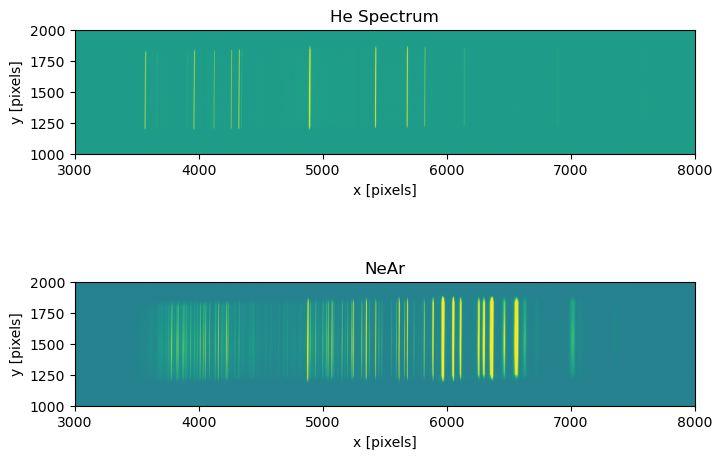

In [7]:
imHe = fits.getdata(he_cal_fname)[2000:4000, :]
imNeAr = fits.getdata(ne_ar_init_fname)[2000:4000, :]
plt.close('all')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
ax1.imshow(imHe, origin='lower', vmin=0, vmax=800)
ax1.set_title("He Spectrum")
ax2.imshow(imNeAr, origin='lower', vmin=0, vmax=1000)
ax2.set_title("NeAr")

for ax in [ax1, ax2]:
    ax.set_xlim([3000, 8000])
    ax.set_ylim([1000, 2000])
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')

# look at all the spectra

In [15]:
obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And', 
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

wavelengths_of_interest_abs = []
wavelengths_of_interest_em = []

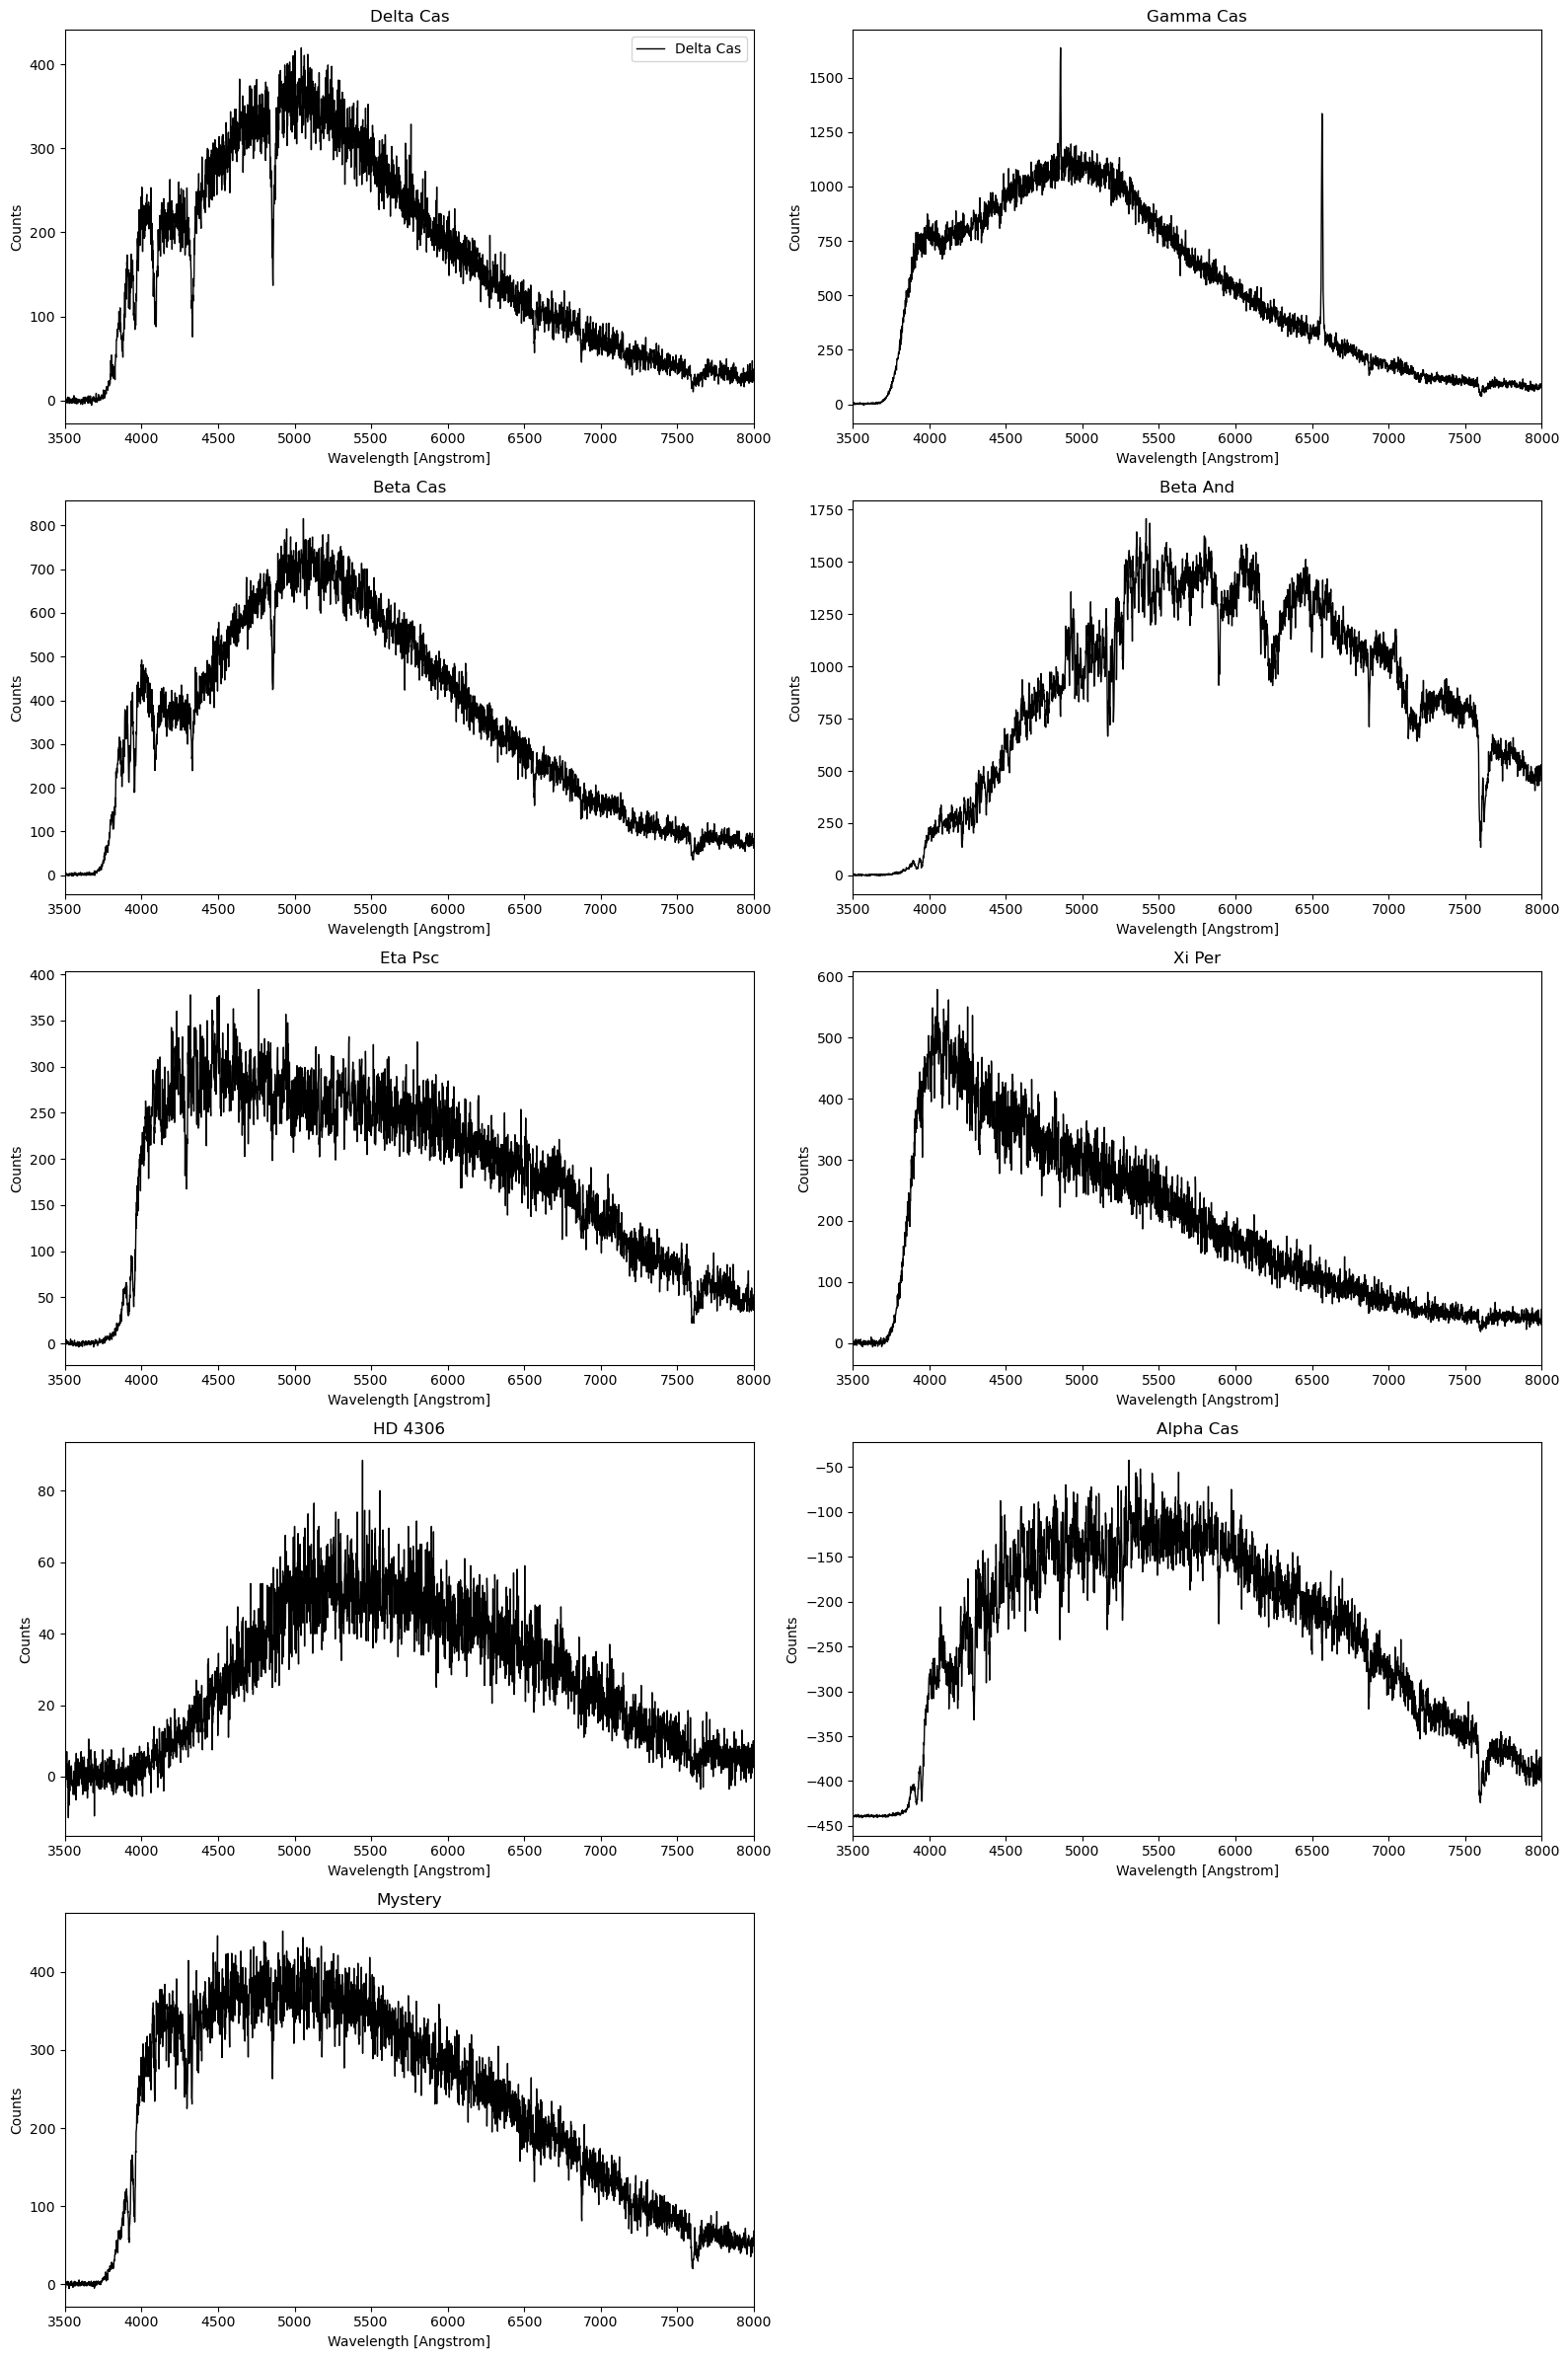

In [16]:
# Plot all science spectra with magenta lines at wavelengths of interest

import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And',
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

science_paths = [
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/del_cas_60s_exp18.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/gam_cas/gam_cas_60s_exp14.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/bet_cas/bet_cas_60s_exp7.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/beta_and/beta_and_60s_exp28.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_2.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_7.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_2.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_calibrated_median.fits',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/mystery/mystery_60s_exp33.fit'
]

near_cal_paths = [
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/ne_ar_cal_15s_exp20.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp16.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp9.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp29.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_wave_cal_near.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_wave_cal_near.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_wave_cal_near.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_wave_cal_near.fit',
    '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp34.fit'
]

master_cals_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/master_cals'
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)
with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)
with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

def load_image(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub
    return sci_calibrated, hdr

def extract_1d_spec(im, y_min, y_max):
    ny, nx = im.shape
    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=200, distance=10, num_peaks=7):
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]
    return sorted_peaks

wavelengths_NeAr = np.array([
    5852.49,
    6965.43,
    7383.9,
    7503.8,
    7635.11,
    7715.0,
    8099.3
])

# Extraction regions for each object (from previous cells)
ymins = [1790, 1740, 1750, 1610, 1610, 1390, 1550, 1380, 1520]
ymaxs = [1850, 1820, 1820, 1680, 1680, 1475, 1585, 1450, 1600]
xmin = 2000
xmax = 5000


plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    def linear_fit(x, y):
        n = len(x)
        sum_x = np.sum(x)
        sum_y = np.sum(y)
        sum_xx = np.sum(x * x)
        sum_xy = np.sum(x * y)
        m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
        b = (sum_y - m * sum_x) / n
        return m, b
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 3500) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # Plot spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, spec_clip, color='black', lw=1, label=obj)
    for w in wavelengths_of_interest_abs:
        plt.axvline(w, color='magenta', linestyle='-', lw=2, label=f'abs: {w} Å' if i == 0 else None)
    for w in wavelengths_of_interest_em:
        plt.axvline(w, color='lime', linestyle='-', lw=2, label=f'em: {w} Å' if i == 0 else None)
    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

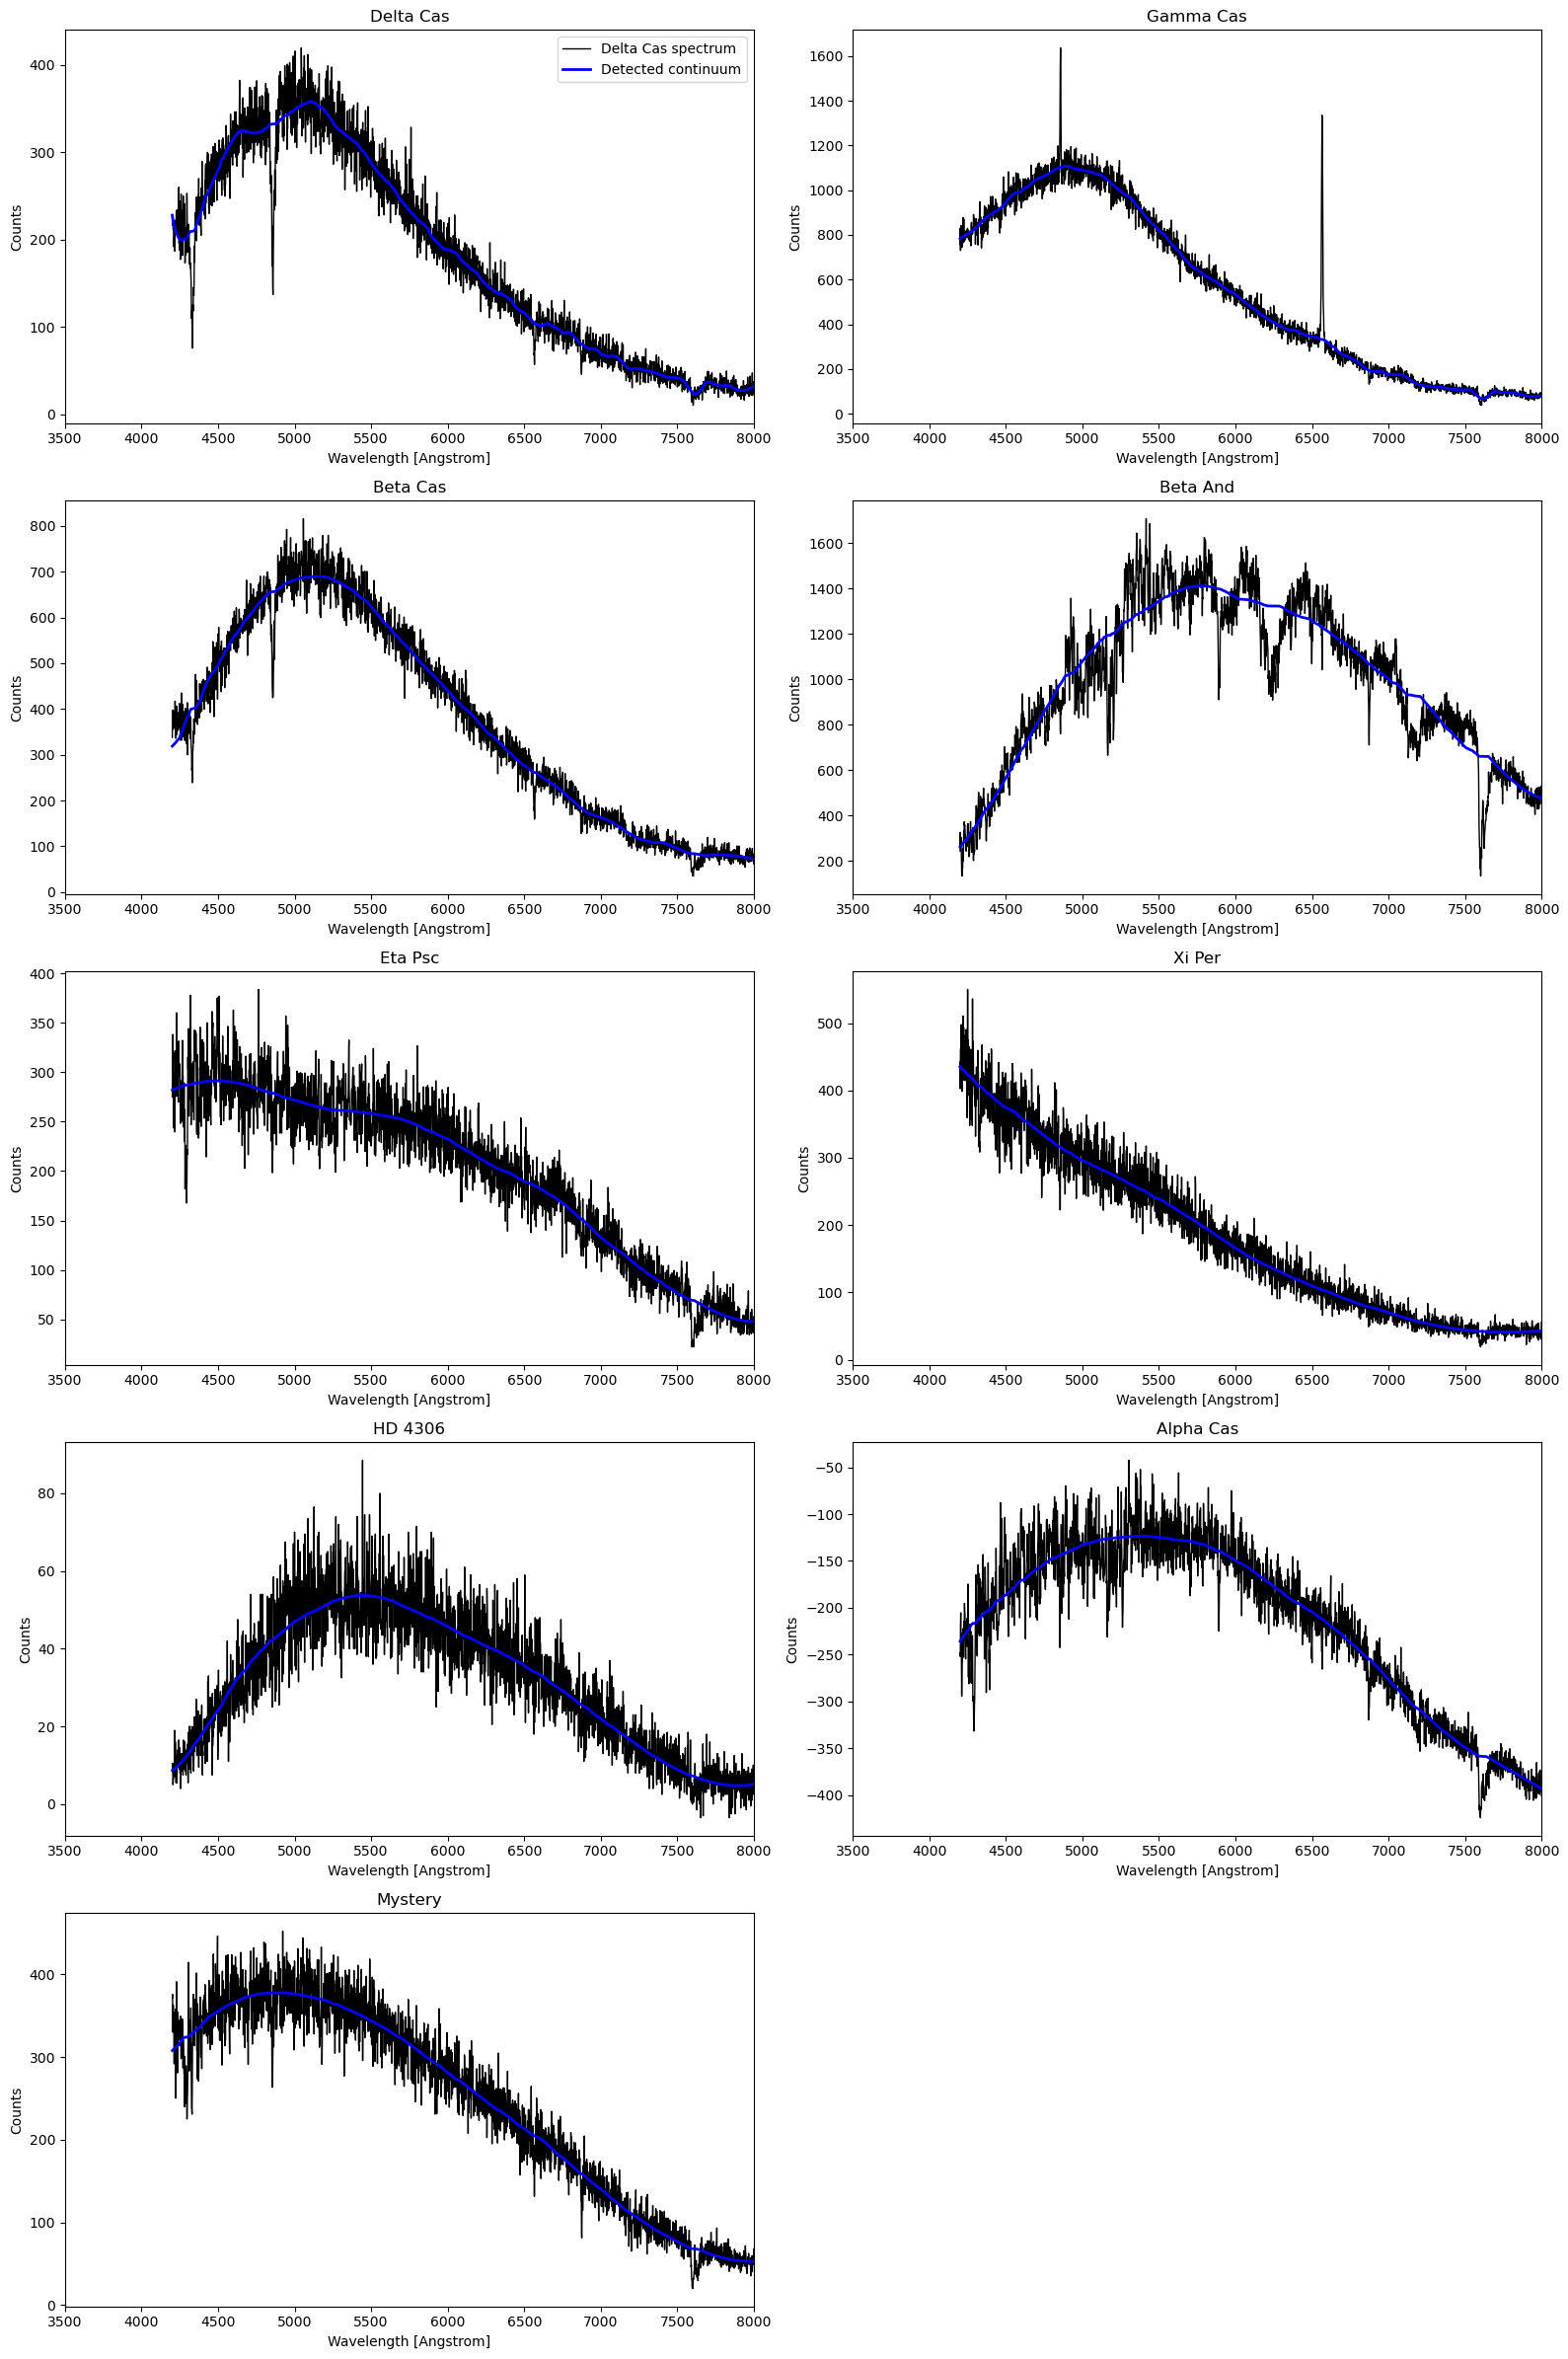

In [ ]:
# ...existing code...

import os
import numpy as np
import matplotlib.pyplot as plt

obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And',
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

# science_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/del_cas_60s_exp18.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/gam_cas/gam_cas_60s_exp14.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/bet_cas/bet_cas_60s_exp7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/beta_and/beta_and_60s_exp28.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_calibrated_median.fits',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/mystery/mystery_60s_exp33.fit'
# ]

# near_cal_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/ne_ar_cal_15s_exp20.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp16.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp9.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp29.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp34.fit'
# ]

ymins = [1790, 1740, 1750, 1610, 1610, 1390, 1550, 1380, 1520]
ymaxs = [1850, 1820, 1820, 1680, 1680, 1475, 1585, 1450, 1600]
xmin = 2000
xmax = 5000

wavelengths_NeAr = np.array([
    5852.49,
    6965.43,
    7383.9,
    7503.8,
    7635.11,
    7715.0,
    8099.3
])


master_cals_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/master_cals'
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)
with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)
with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

def load_image(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub
    return sci_calibrated, hdr

def extract_1d_spec(im, y_min, y_max):
    ny, nx = im.shape
    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=200, distance=10, num_peaks=7):
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]
    return sorted_peaks

def linear_fit(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)
    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n
    return m, b

# Specific Savitzky-Golay window lengths for each object (from your individual analysis)
sg_windows_1 = [550, 550, 1550, 950, 250, 950, 950, 950, 950]  # first smooth
sg_windows_2 = [150, 150, 350, 1050, 750, 1050, 1050, 1050, 1050]  # second smooth

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4200) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM DETECTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Plot original spectrum with detected continuum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, spec_clip, color='black', lw=1, label=f'{obj} spectrum')
    plt.plot(wl_clip, cont_final, color='blue', lw=2, label='Detected continuum')
    for w in wavelengths_of_interest_abs:
        plt.axvline(w, color='magenta', linestyle='-', lw=2, label=f'abs: {w} Å' if i == 0 else None)
    for w in wavelengths_of_interest_em:
        plt.axvline(w, color='lime', linestyle='-', lw=2, label=f'em: {w} Å' if i == 0 else None)
    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

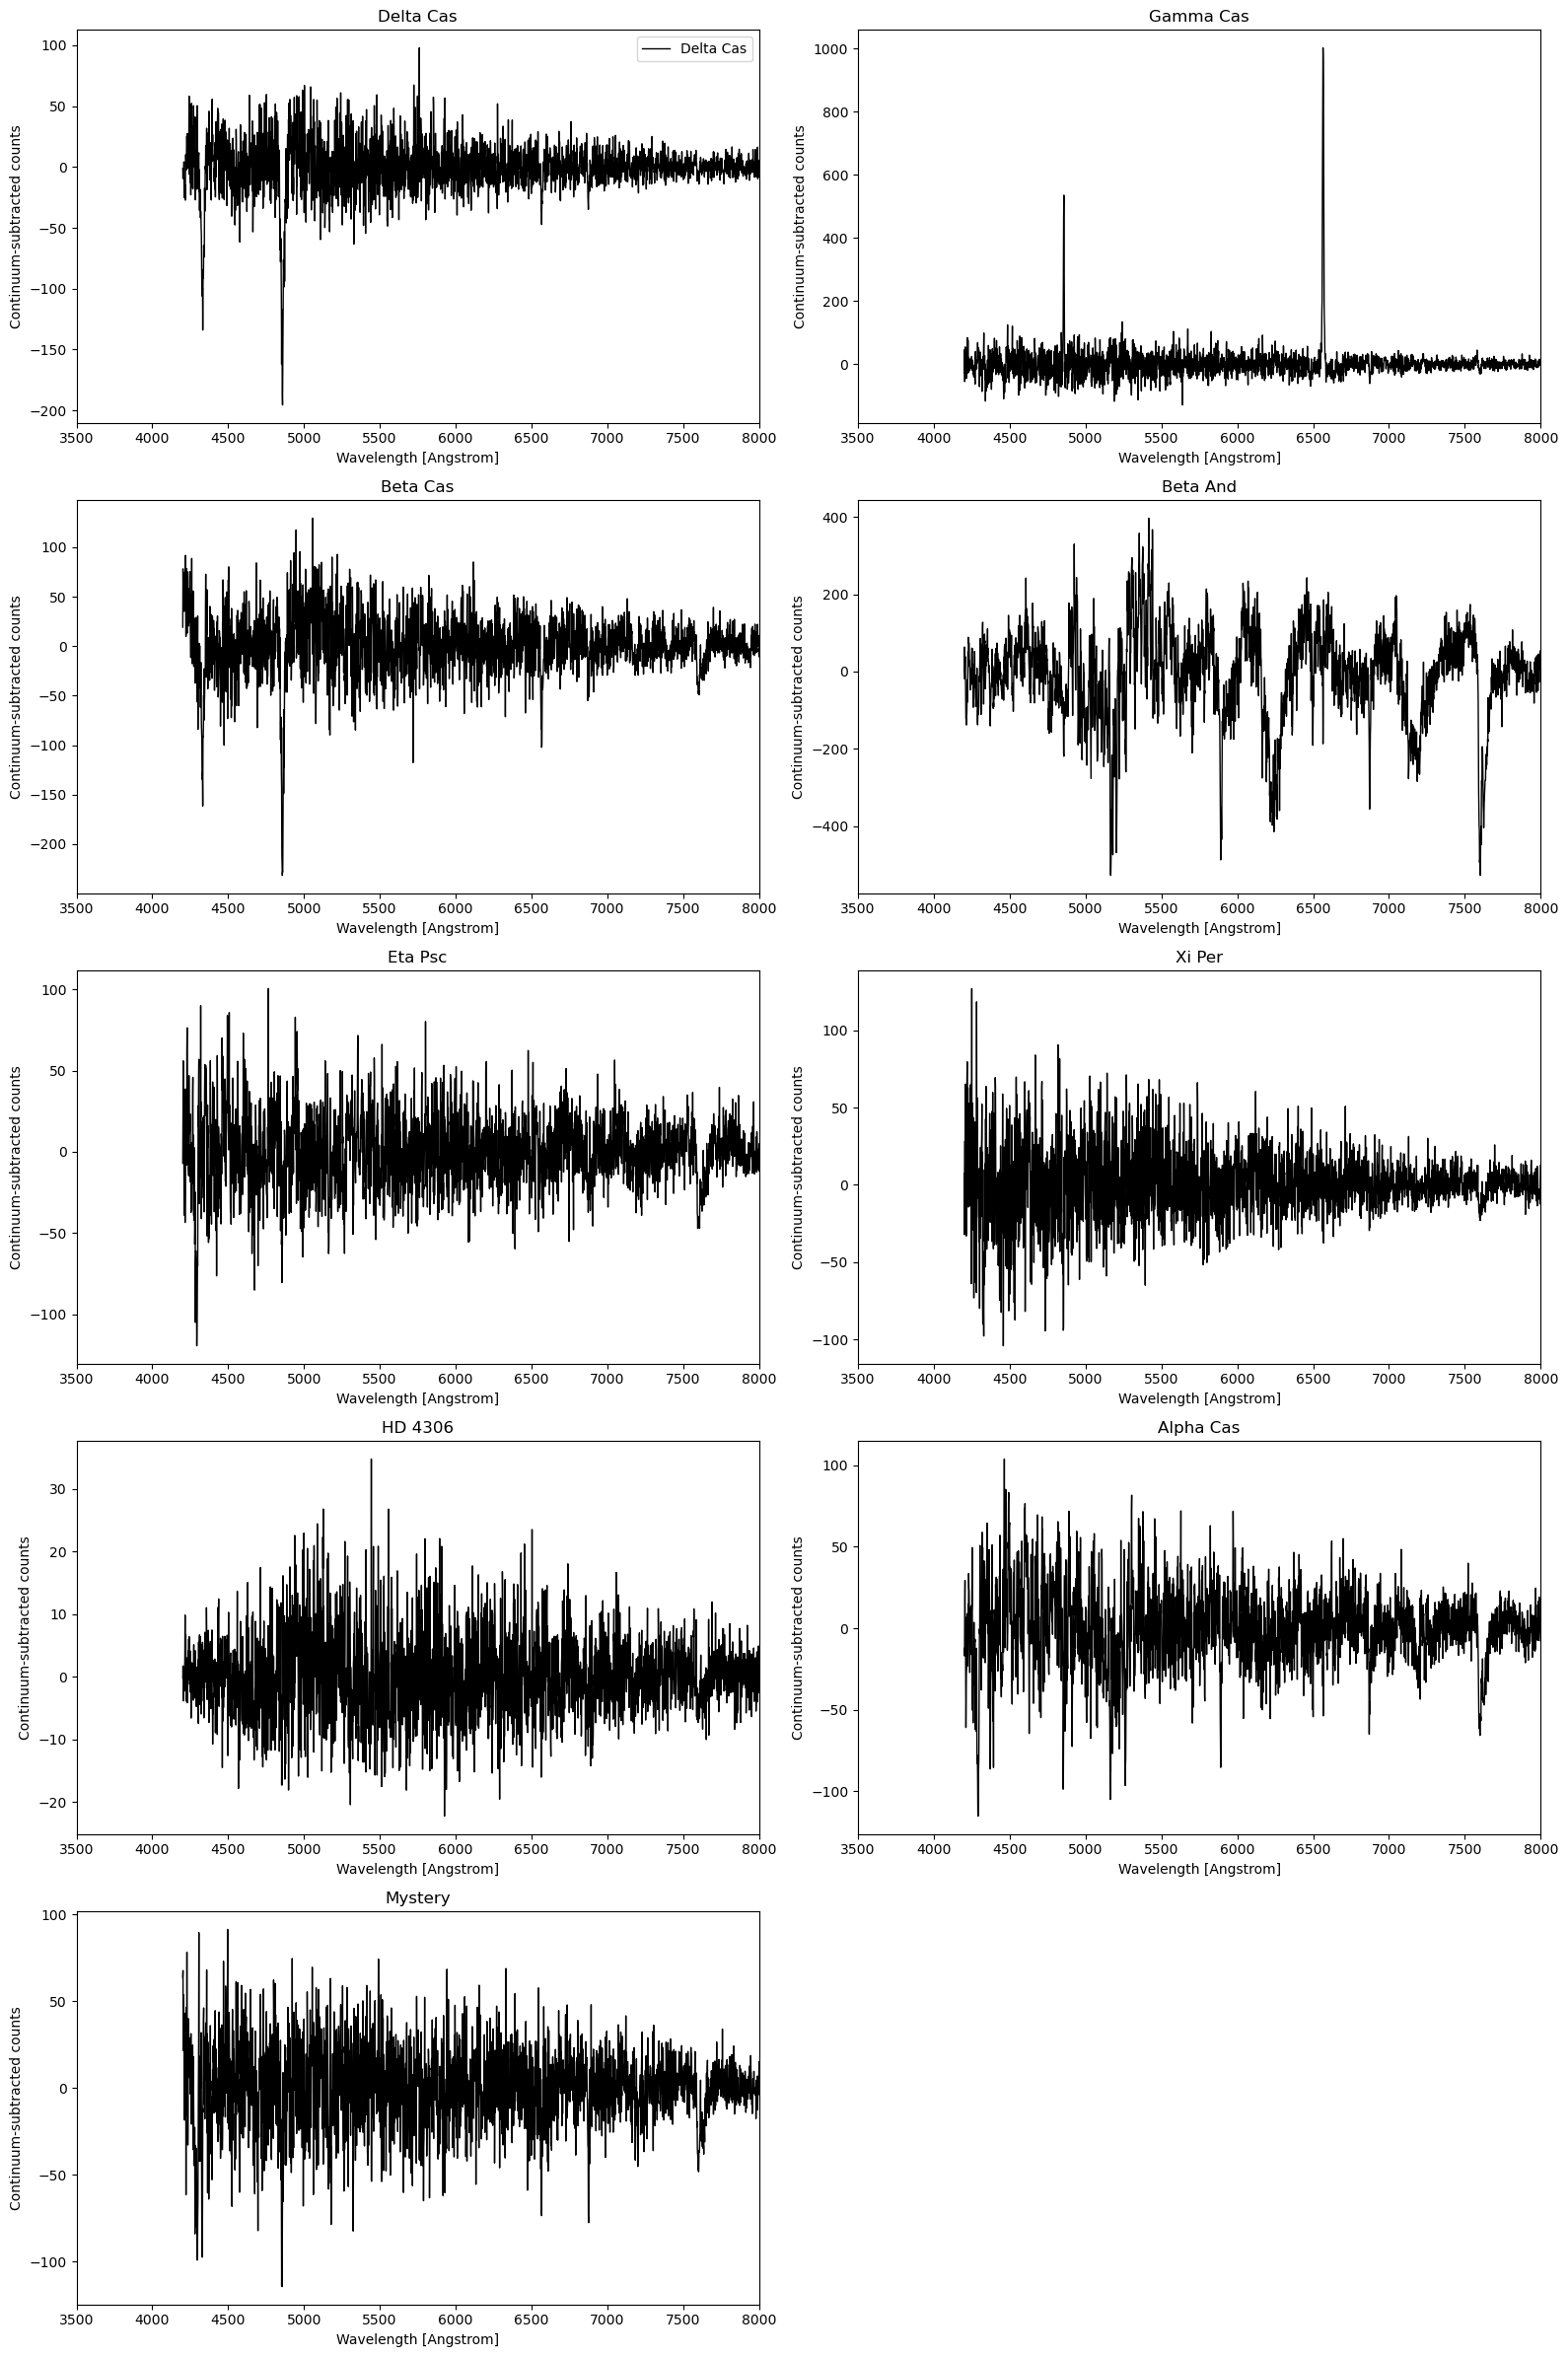

In [ ]:
# ...existing code...

import os
import numpy as np
import matplotlib.pyplot as plt

obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And',
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

# science_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/del_cas_60s_exp18.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/gam_cas/gam_cas_60s_exp14.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/bet_cas/bet_cas_60s_exp7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/beta_and/beta_and_60s_exp28.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_calibrated_median.fits',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/mystery/mystery_60s_exp33.fit'
# ]

# near_cal_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/ne_ar_cal_15s_exp20.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp16.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp9.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp29.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp34.fit'
# ]

ymins = [1790, 1740, 1750, 1610, 1610, 1390, 1550, 1380, 1520]
ymaxs = [1850, 1820, 1820, 1680, 1680, 1475, 1585, 1450, 1600]
xmin = 2000
xmax = 5000

wavelengths_NeAr = np.array([
    5852.49,
    6965.43,
    7383.9,
    7503.8,
    7635.11,
    7715.0,
    8099.3
])


master_cals_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/master_cals'
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)
with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)
with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

def load_image(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub
    return sci_calibrated, hdr

def extract_1d_spec(im, y_min, y_max):
    ny, nx = im.shape
    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=200, distance=10, num_peaks=7):
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]
    return sorted_peaks

def linear_fit(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)
    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n
    return m, b

# Specific Savitzky-Golay window lengths for each object (from your individual analysis)
sg_windows_1 = [550, 550, 1550, 950, 250, 950, 950, 950, 950]  # first smooth
sg_windows_2 = [150, 150, 350, 1050, 750, 1050, 1050, 1050, 1050]  # second smooth

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4200) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    # First Savitzky-Golay smooth (object-specific window)
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    # Second Savitzky-Golay smooth on masked continuum points, then interpolate (object-specific window)
    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # Plot continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, continuum_subtracted, color='black', lw=1, label=obj)
    for w in wavelengths_of_interest_abs:
        plt.axvline(w, color='magenta', linestyle='-', lw=2, label=f'abs: {w} Å' if i == 0 else None)

    for w in wavelengths_of_interest_em:
        plt.axvline(w, color='lime', linestyle='-', lw=2, label=f'em: {w} Å' if i == 0 else None)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

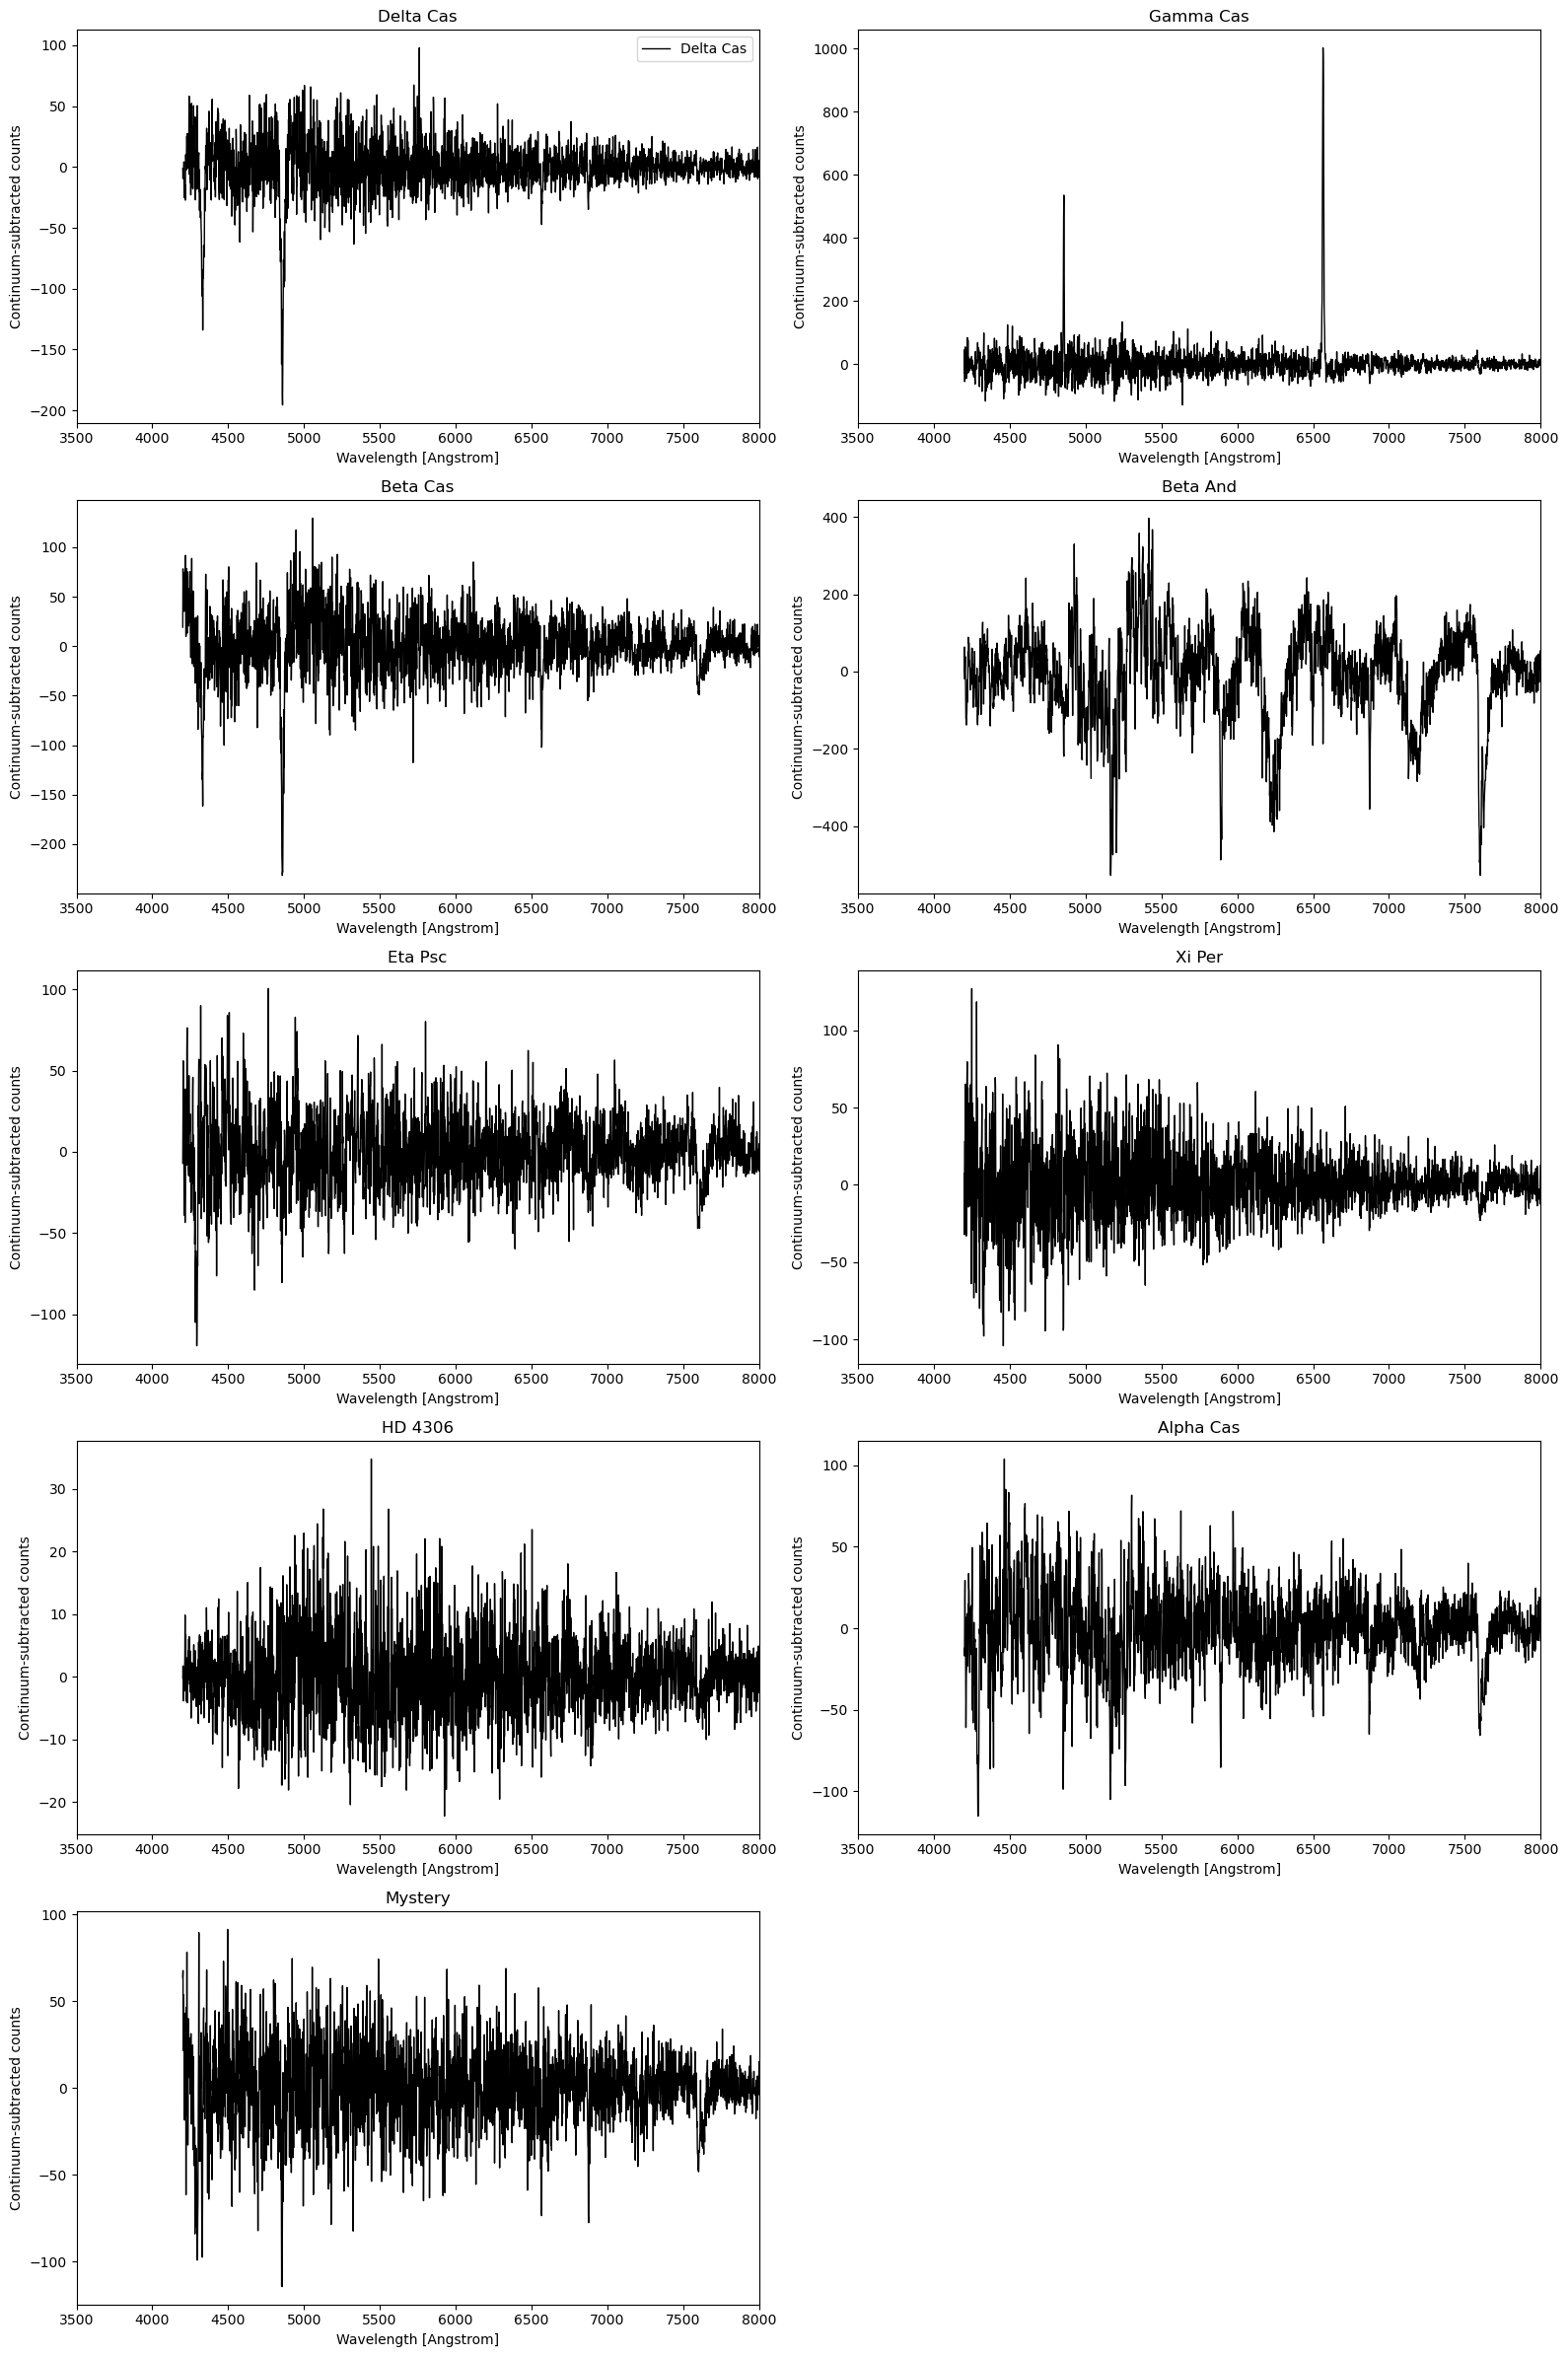

In [ ]:
# ...existing code...

import os
import numpy as np
import matplotlib.pyplot as plt

obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And',
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

# science_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/del_cas_60s_exp18.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/gam_cas/gam_cas_60s_exp14.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/bet_cas/bet_cas_60s_exp7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/beta_and/beta_and_60s_exp28.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_calibrated_median.fits',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/mystery/mystery_60s_exp33.fit'
# ]

# near_cal_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/ne_ar_cal_15s_exp20.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp16.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp9.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp29.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp34.fit'
# ]

ymins = [1790, 1740, 1750, 1610, 1610, 1390, 1550, 1380, 1520]
ymaxs = [1850, 1820, 1820, 1680, 1680, 1475, 1585, 1450, 1600]
xmin = 2000
xmax = 5000

wavelengths_NeAr = np.array([
    5852.49,
    6965.43,
    7383.9,
    7503.8,
    7635.11,
    7715.0,
    8099.3
])


master_cals_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/master_cals'
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)
with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)
with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

def load_image(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub
    return sci_calibrated, hdr

def extract_1d_spec(im, y_min, y_max):
    ny, nx = im.shape
    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=200, distance=10, num_peaks=7):
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]
    return sorted_peaks

def linear_fit(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)
    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n
    return m, b

# Specific Savitzky-Golay window lengths for each object (from your individual analysis)
sg_windows_1 = [550, 550, 1550, 950, 250, 950, 950, 950, 950]  # first smooth
sg_windows_2 = [150, 150, 350, 1050, 750, 1050, 1050, 1050, 1050]  # second smooth

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4200) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    # First Savitzky-Golay smooth (object-specific window)
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    # Second Savitzky-Golay smooth on masked continuum points, then interpolate (object-specific window)
    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # Plot continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, continuum_subtracted, color='black', lw=1, label=obj)
    for w in wavelengths_of_interest_abs:
        plt.axvline(w, color='magenta', linestyle='-', lw=2, label=f'abs: {w} Å' if i == 0 else None)

    for w in wavelengths_of_interest_em:
        plt.axvline(w, color='lime', linestyle='-', lw=2, label=f'em: {w} Å' if i == 0 else None)
    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

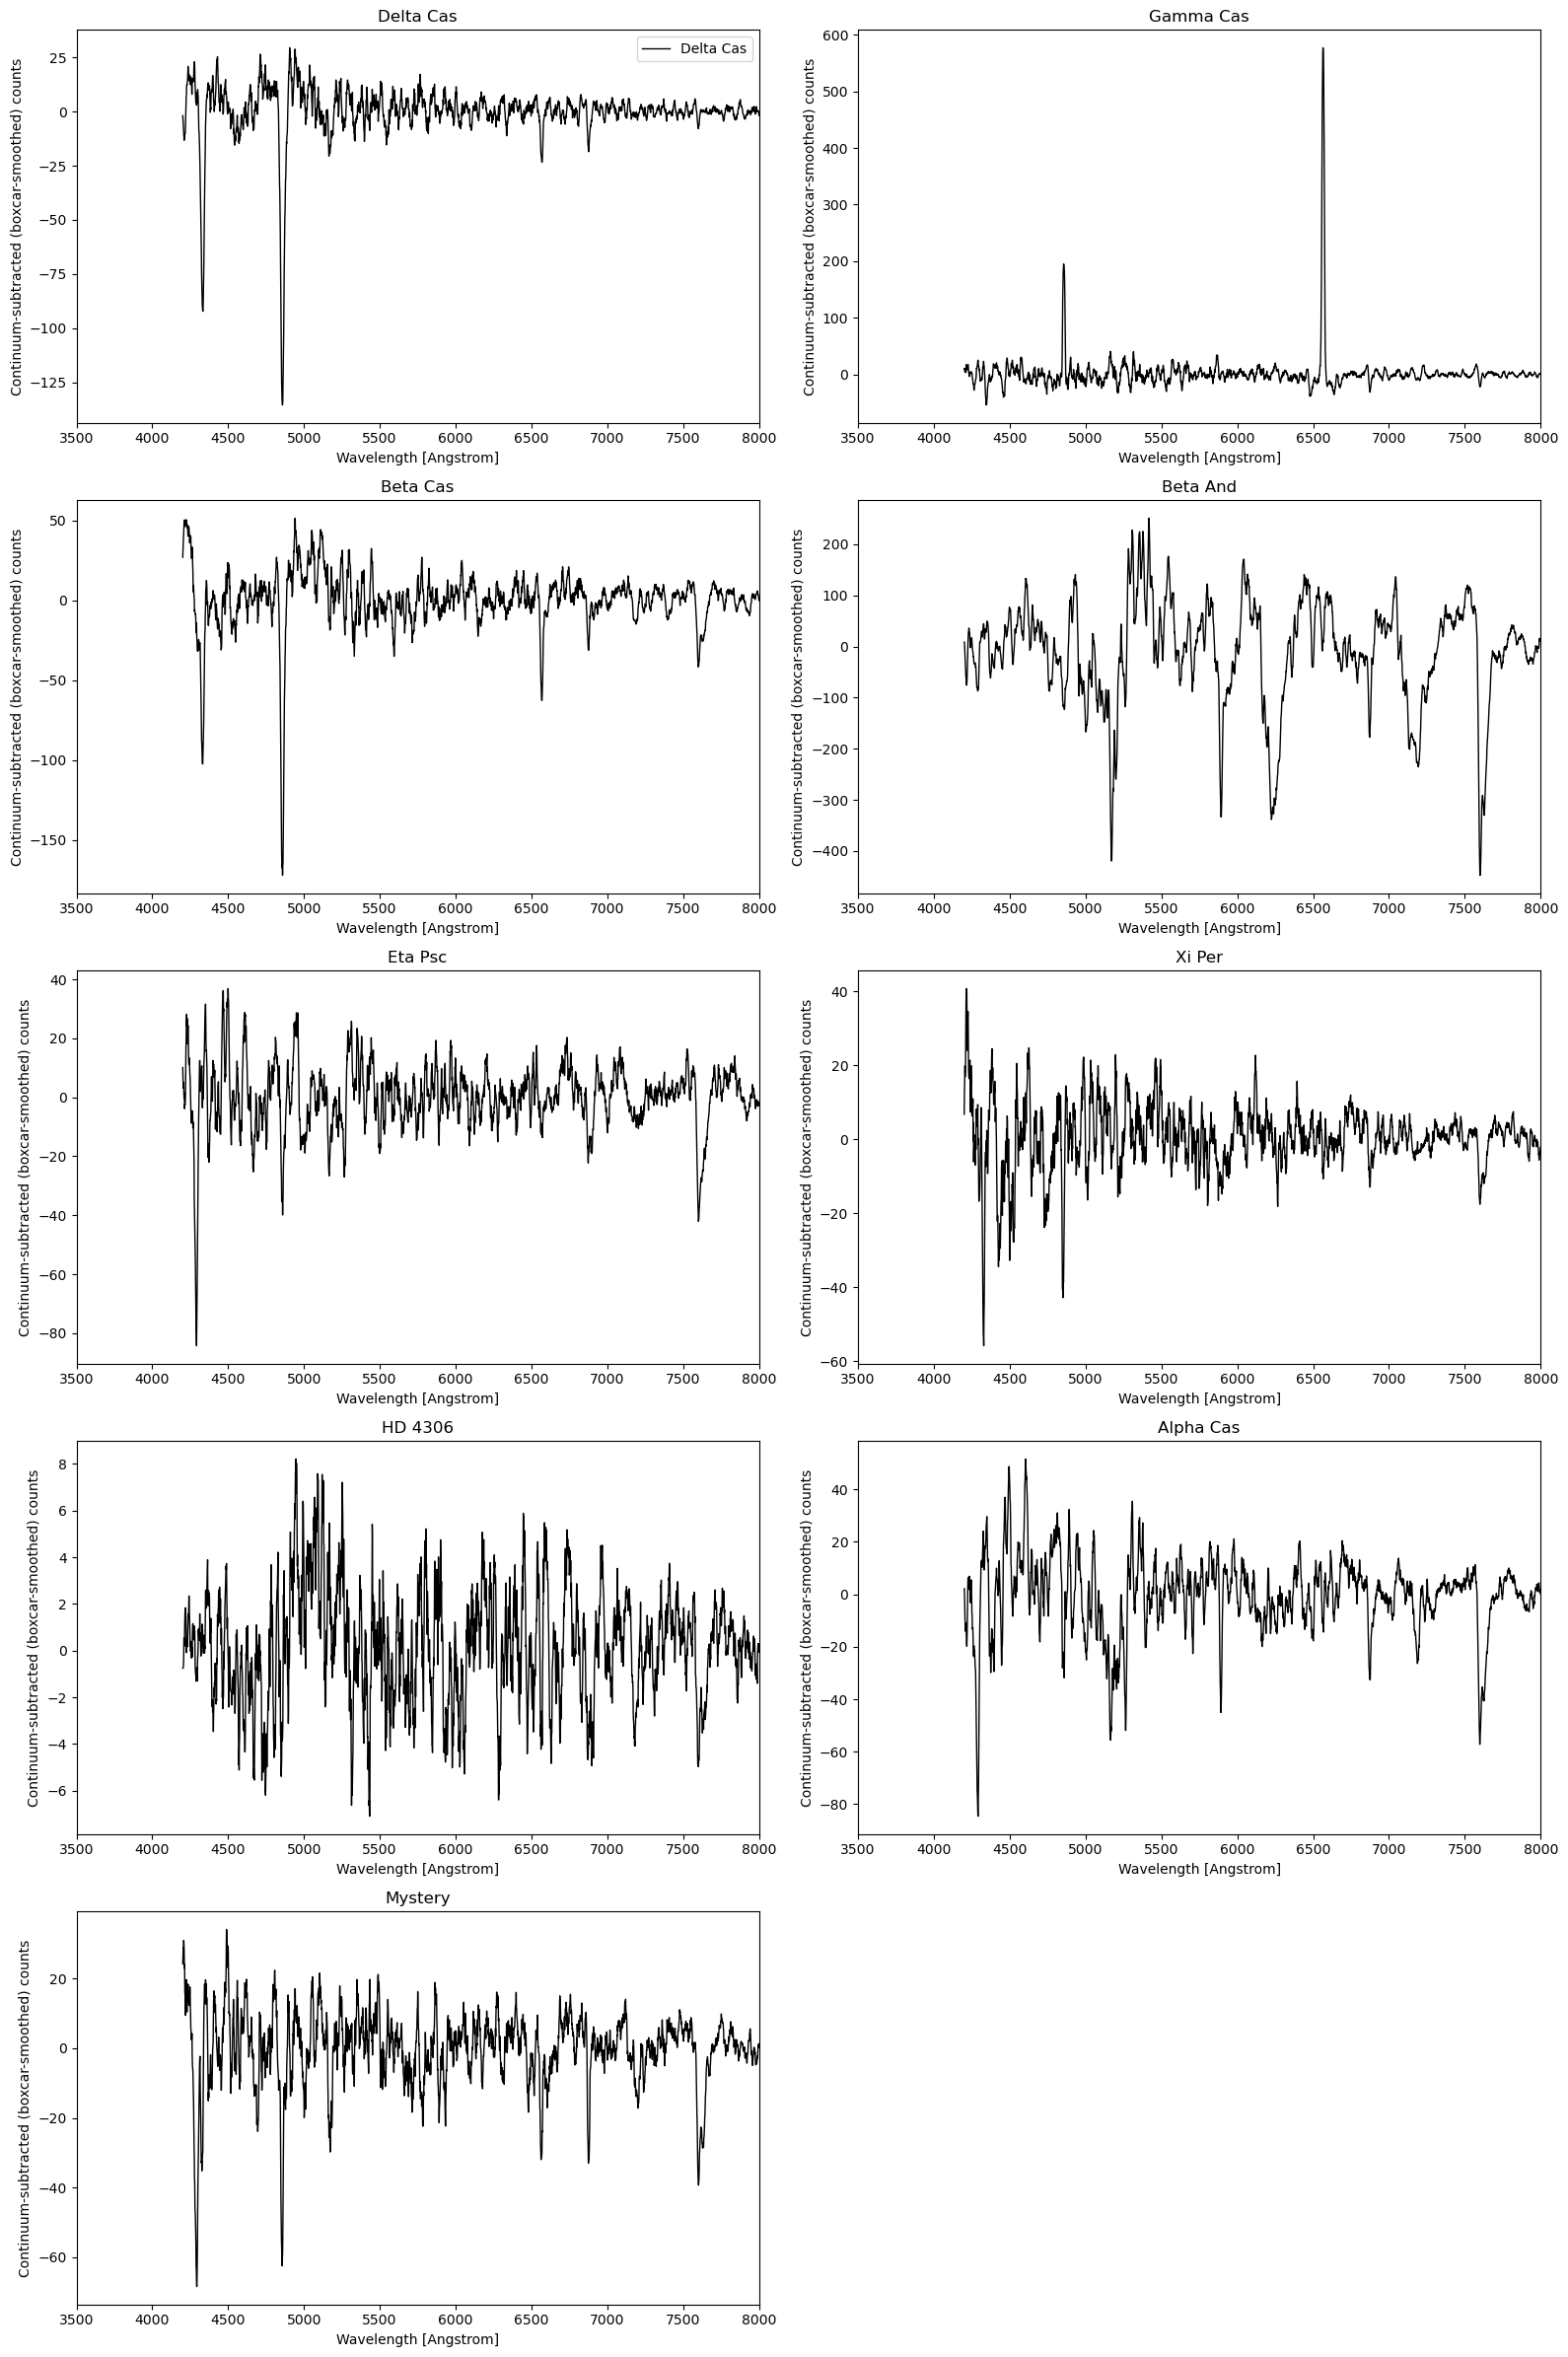

In [ ]:
# ...existing code...

import os
import numpy as np
import matplotlib.pyplot as plt

obj_names = ['Delta Cas', 'Gamma Cas', 'Beta Cas', 'Beta And',
             'Eta Psc', 'Xi Per', 'HD 4306', 'Alpha Cas', 'Mystery']

# science_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/del_cas_60s_exp18.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/gam_cas/gam_cas_60s_exp14.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/bet_cas/bet_cas_60s_exp7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/beta_and/beta_and_60s_exp28.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_7.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_2.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_calibrated_median.fits',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/mystery/mystery_60s_exp33.fit'
# ]

# near_cal_paths = [
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/del_cas/ne_ar_cal_15s_exp20.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp16.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp9.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp29.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/eta_psc/eta_psc_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/Xi_per/xi_per_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/hd4306/hd4306_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/alpha_cas/alpha_cas_wave_cal_near.fit',
#     '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/wl_cals/ne_ar_cal_15s_exp34.fit'
# ]

ymins = [1790, 1740, 1750, 1610, 1610, 1390, 1550, 1380, 1520]
ymaxs = [1850, 1820, 1820, 1680, 1680, 1475, 1585, 1450, 1600]
xmin = 2000
xmax = 5000

wavelengths_NeAr = np.array([
    5852.49,
    6965.43,
    7383.9,
    7503.8,
    7635.11,
    7715.0,
    8099.3
])

master_cals_dir = '/Users/rqy2qb/DataAnalysis/Observational/Lab3/data/master_cals'
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

from astropy.io import fits
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)
with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)
with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

def load_image(fname):
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub
    return sci_calibrated, hdr

def extract_1d_spec(im, y_min, y_max):
    ny, nx = im.shape
    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=200, distance=10, num_peaks=7):
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]
    return sorted_peaks

def linear_fit(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)
    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n
    return m, b

# Boxcar smoothing function
def boxcar_smooth(y, N=11):
    box = np.ones(N) / N
    return np.convolve(y, box, mode='same')

# Specific Savitzky-Golay window lengths for each object (from your individual analysis)
sg_windows_1 = [550, 550, 1550, 950, 250, 950, 950, 950, 950]  # first smooth
sg_windows_2 = [150, 150, 350, 1050, 750, 1050, 1050, 1050, 1050]  # second smooth

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4200) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)
    # for w in wavelengths_of_interest_abs:
    #     plt.axvline(w, color='magenta', linestyle='-', lw=2, label=f'abs: {w} Å' if i == 0 else None)

    # for w in wavelengths_of_interest_em:
    #     plt.axvline(w, color='lime', linestyle='-', lw=2, label=f'em: {w} Å' if i == 0 else None)
    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# O type

In [21]:
# ...existing code...

# --- Add O-type line labels ---
O_abs = {
    4026: "He I 4026 (late type only)",
    4101: "Hδ 4101",
    4200: "He II 4200 (weak)",
    4340: "Hγ 4340",
    4471: "He I 4471",
    4542: "He II 4542 (early type only)",
    4861: "Hβ 4861"
}
O_em = {
    4630: "N III 4630 (emission)",
    4686: "He II 4686 (early type emission, late type absorption)"
}
wavelengths_of_interest_abs = list(O_abs.keys())
wavelengths_of_interest_em = list(O_em.keys())

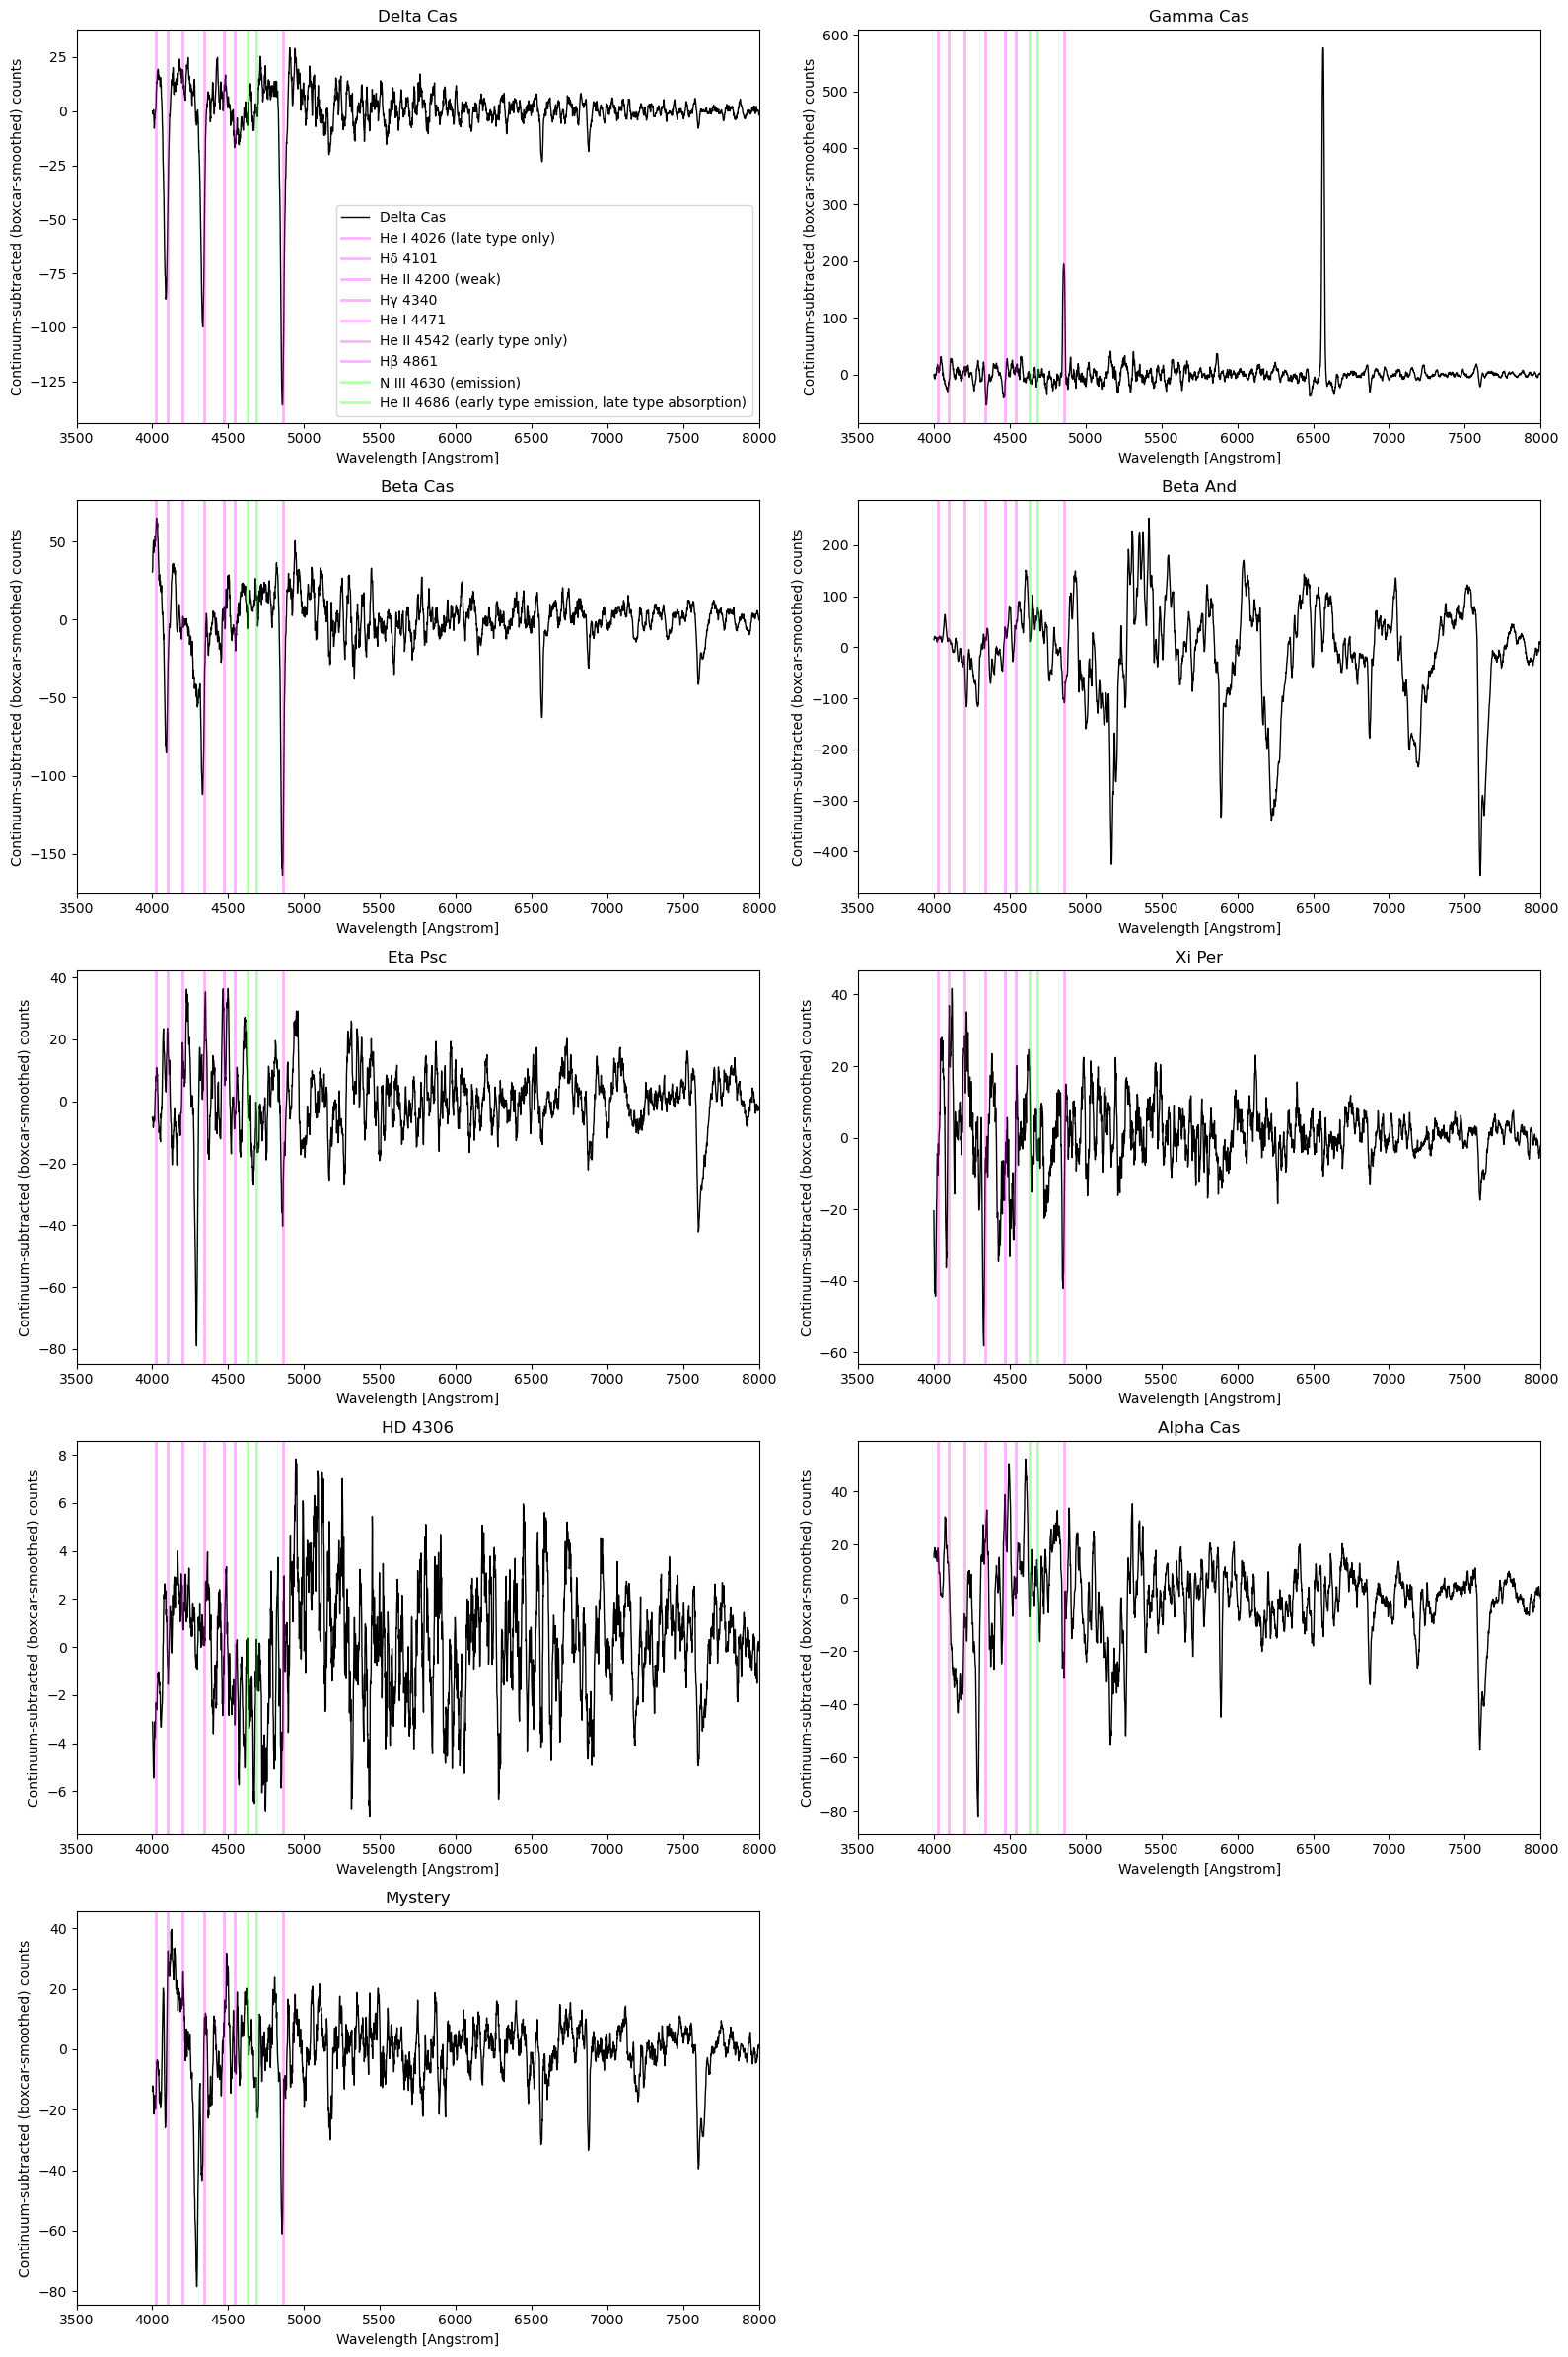

In [22]:
# ...existing code...

# --- Add O-type line labels ---
O_abs = {
    4026: "He I 4026 (late type only)",
    4101: "Hδ 4101",
    4200: "He II 4200 (weak)",
    4340: "Hγ 4340",
    4471: "He I 4471",
    4542: "He II 4542 (early type only)",
    4861: "Hβ 4861"
}
O_em = {
    4630: "N III 4630 (emission)",
    4686: "He II 4686 (early type emission, late type absorption)"
}
wavelengths_of_interest_abs = list(O_abs.keys())
wavelengths_of_interest_em = list(O_em.keys())

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4000) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)

    # Only add each label once to the legend (on the first subplot)
    shown_abs = set()
    shown_em = set()
    for w in wavelengths_of_interest_abs:
        label = O_abs[w] if (i == 0 and w not in shown_abs) else None
        plt.axvline(w, color='magenta', linestyle='-', alpha=0.3, lw=2, label=label)
        shown_abs.add(w)
    for w in wavelengths_of_interest_em:
        label = O_em[w] if (i == 0 and w not in shown_em) else None
        plt.axvline(w, color='lime', linestyle='-', lw=2, alpha=0.3, label=label)
        shown_em.add(w)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# B type

In [23]:
B_abs = np.array([3819, 3970, 4026, 4101, 4144, 4340, 4387, 4471, 4481, 4861]) 

wavelengths_of_interest_abs = B_abs
wavelengths_of_interest_em = []
"""
4144 only for B2V, 
4387 early type only 
4471 early type only
4481 late type only, WEAK
"""


# ...existing code...

# --- Add B-type line labels ---
B_abs = np.array([3819, 3970, 4026, 4101, 4144, 4340, 4387, 4471, 4481, 4861])
B_abs_labels = {
    3819: "He I 3819",
    3970: "Hε 3970",
    4026: "He I 4026",
    4101: "Hδ 4101",
    4144: "Si II 4144 (B2V only)",
    4340: "Hγ 4340",
    4387: "He I 4387 (early type only)",
    4471: "He I 4471 (early type only)",
    4481: "Mg II 4481 (late type only, WEAK)",
    4861: "Hβ 4861"
}
wavelengths_of_interest_abs = list(B_abs_labels.keys())
wavelengths_of_interest_em = []


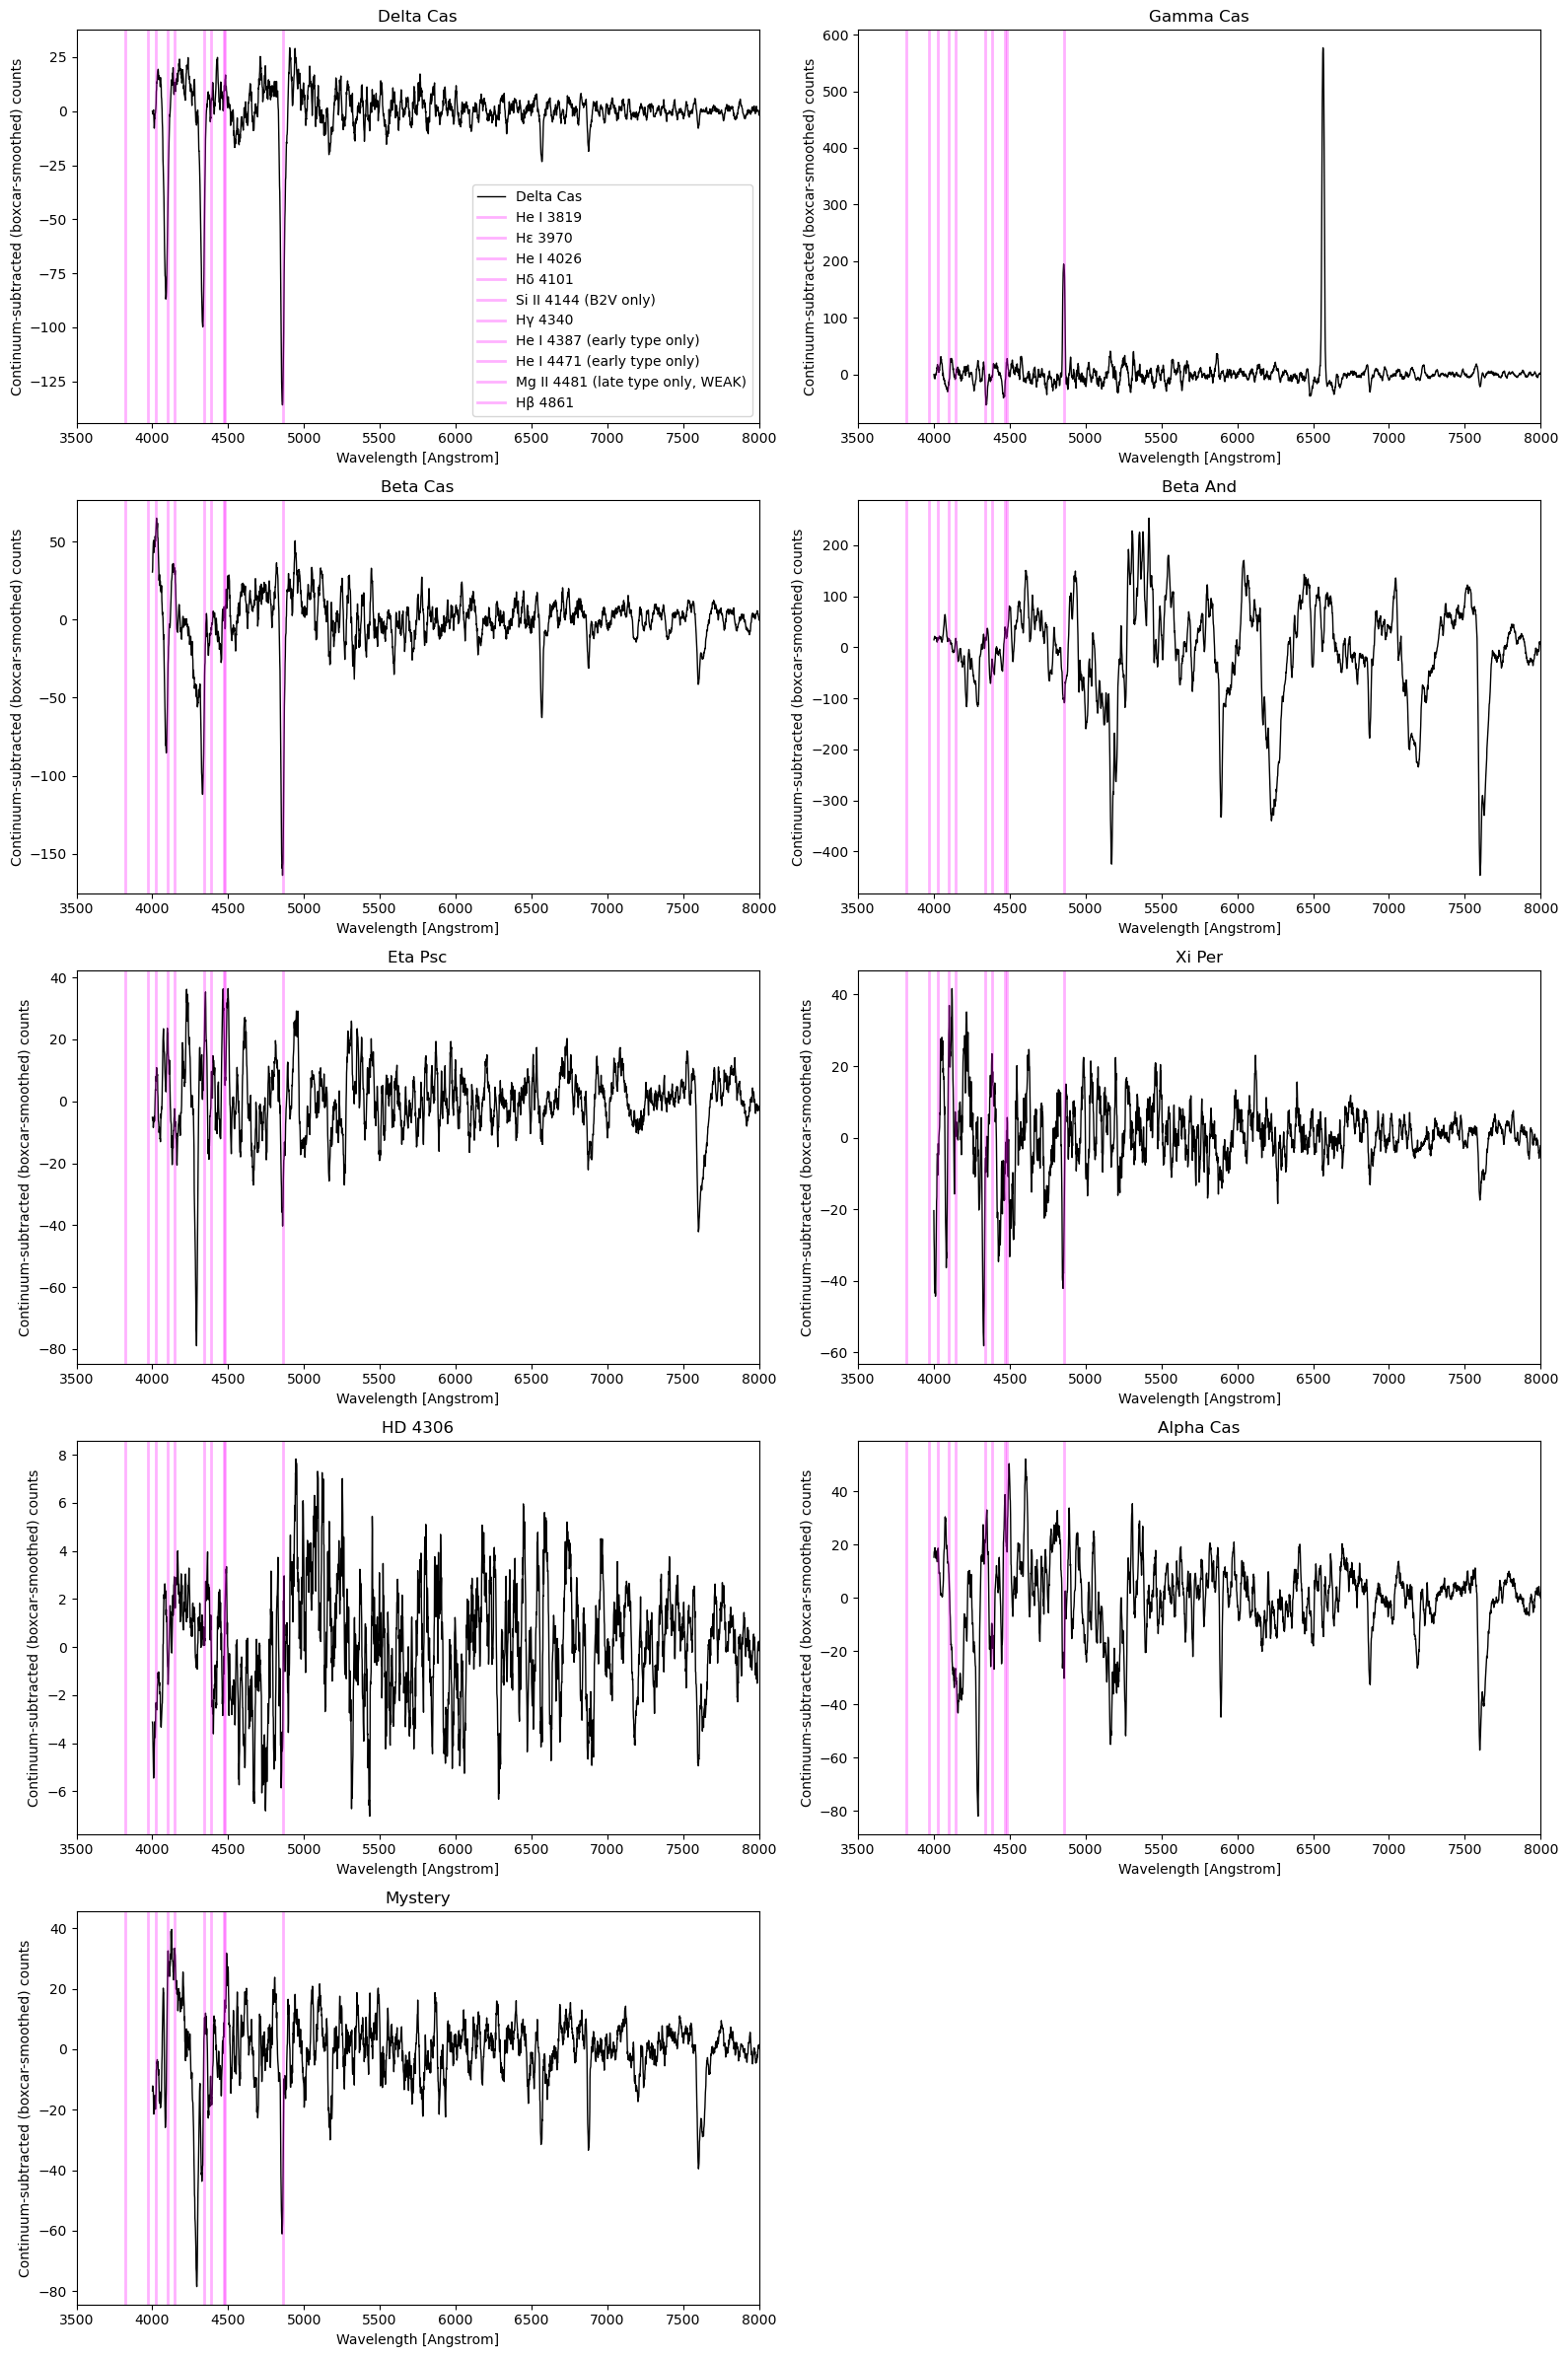

In [24]:
# ...existing code...

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4000) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)

    # Only add each label once to the legend (on the first subplot)
    shown_abs = set()
    for w in wavelengths_of_interest_abs:
        label = B_abs_labels[w] if (i == 0 and w not in shown_abs) else None
        plt.axvline(w, color='magenta', linestyle='-', alpha=0.3, lw=2, label=label)
        shown_abs.add(w)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# A type

In [25]:
A_abs = np.array([3933, 3968, 4101, 4340, 4861])

wavelengths_of_interest_abs = A_abs
wavelengths_of_interest_em = []

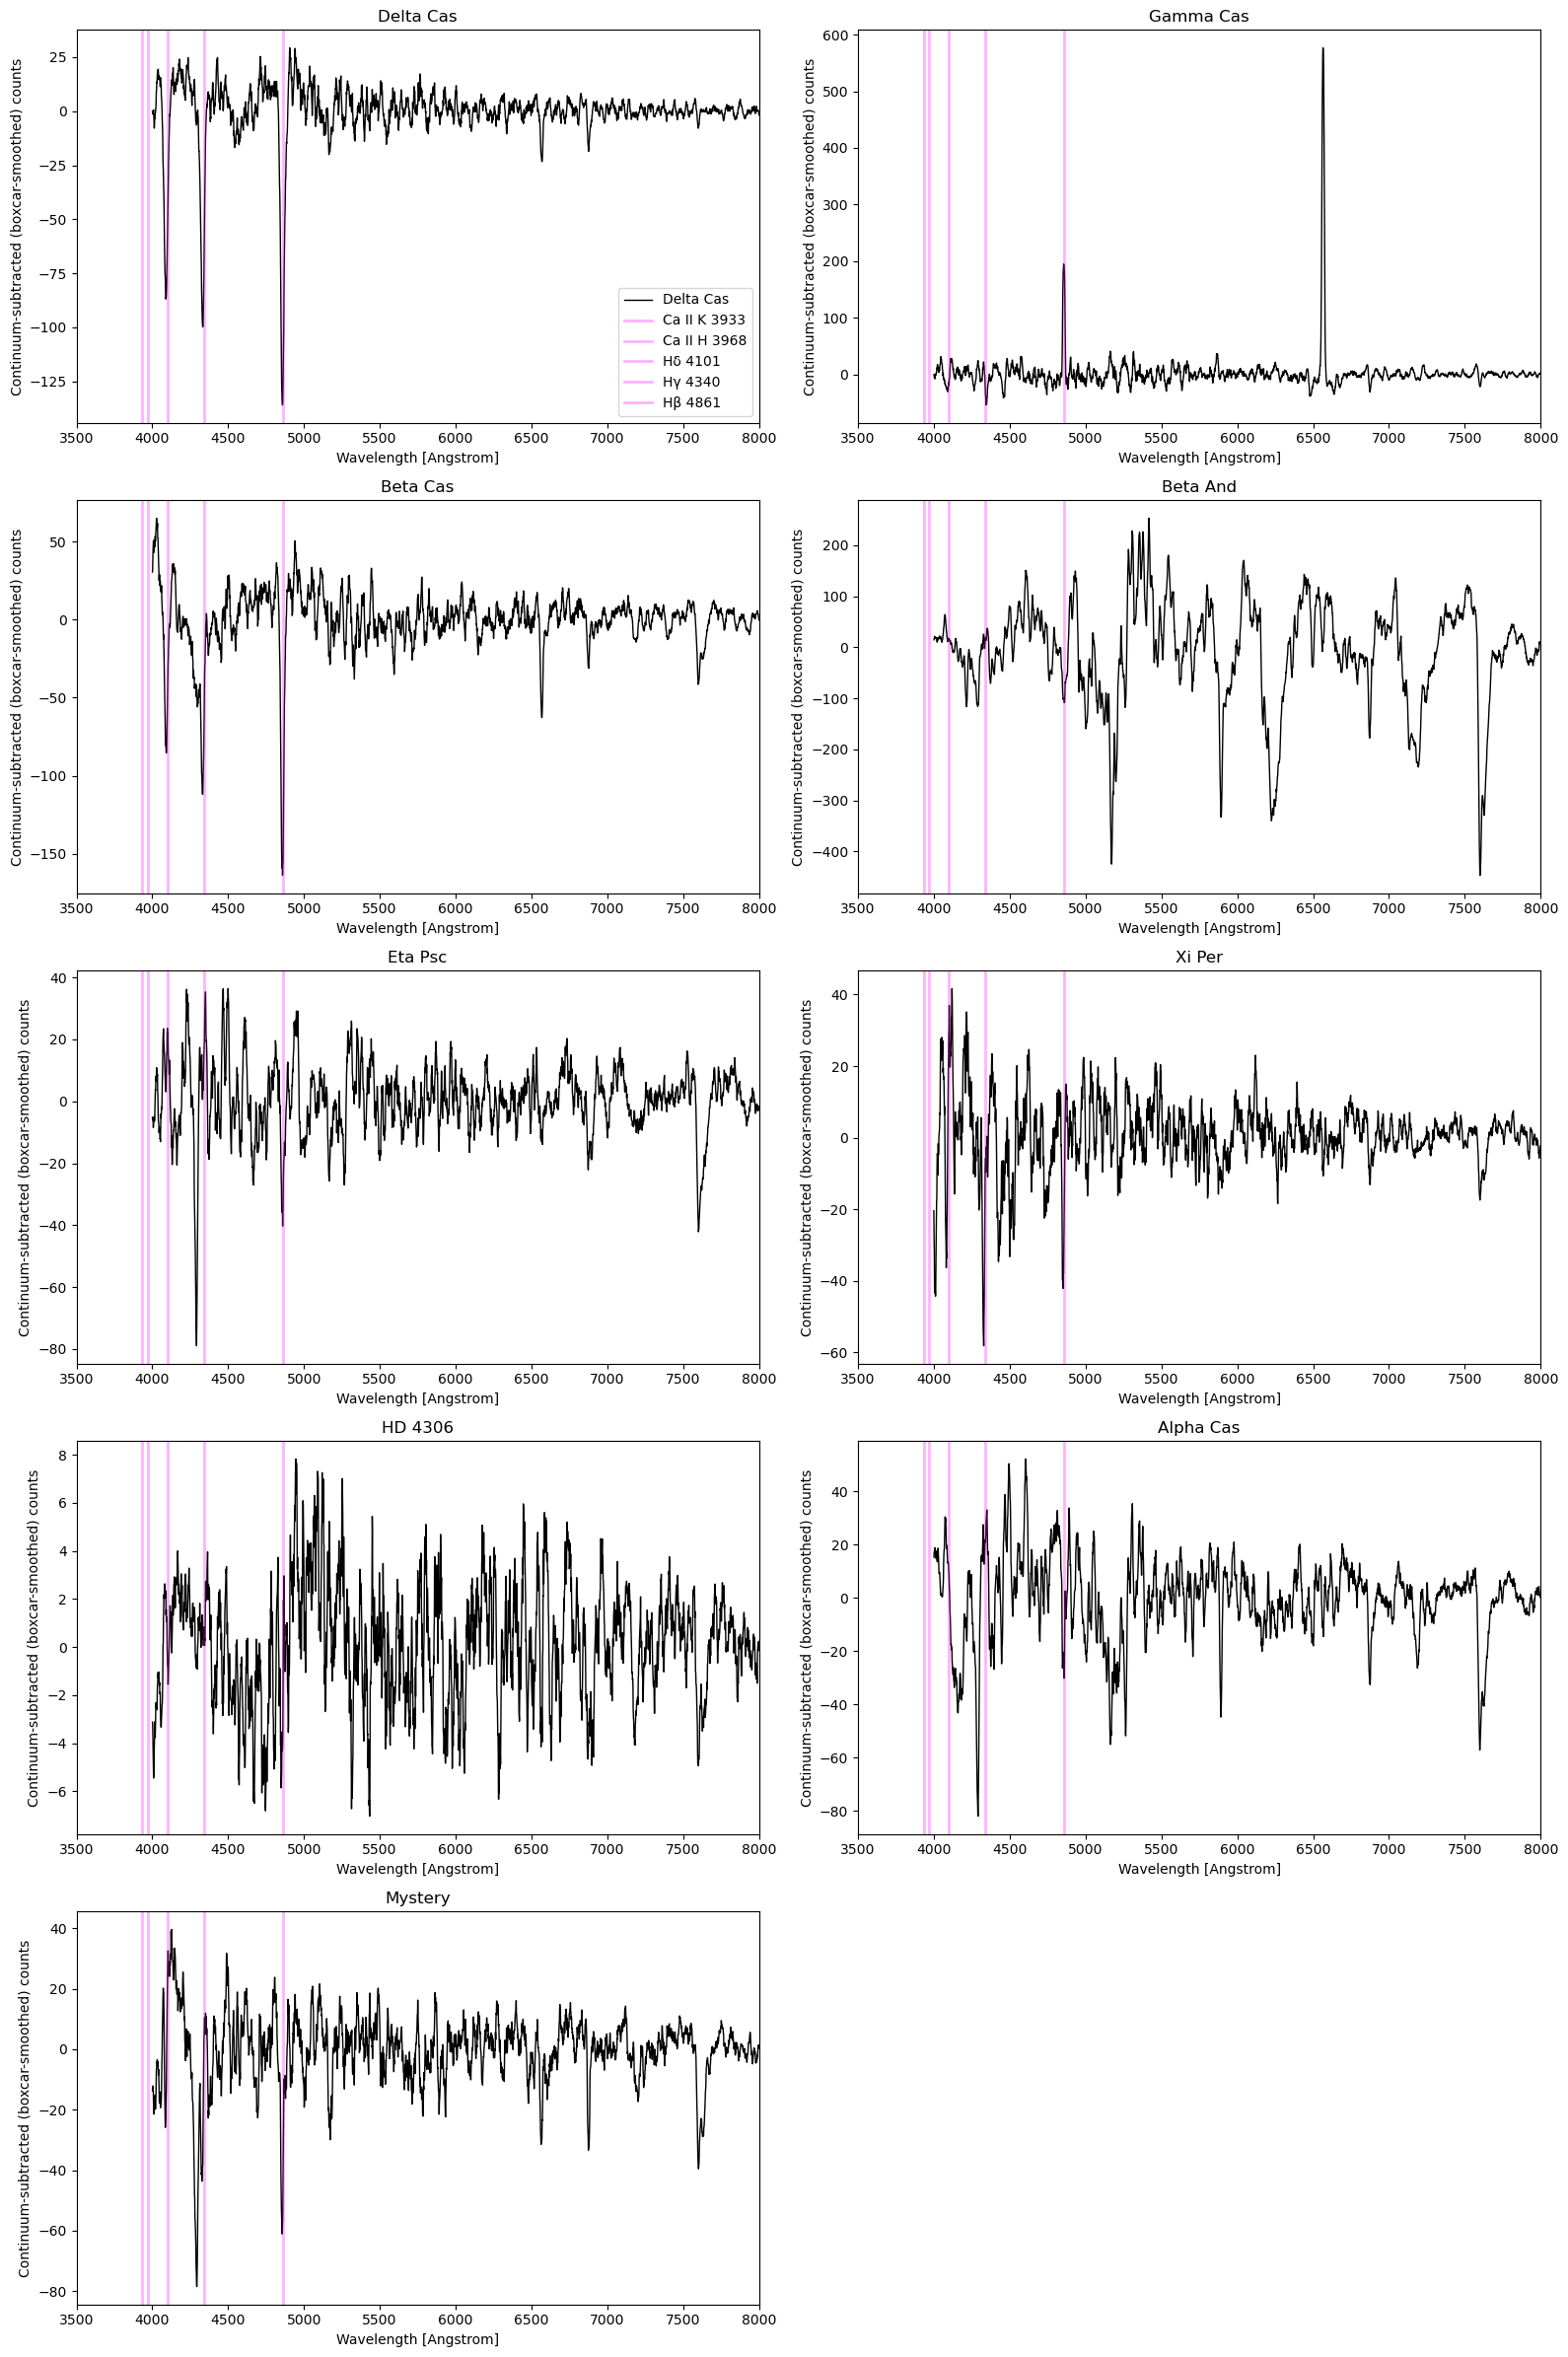

In [26]:
# ...existing code...

# --- Add A-type line labels ---
A_abs = np.array([3933, 3968, 4101, 4340, 4861])
A_abs_labels = {
    3933: "Ca II K 3933",
    3968: "Ca II H 3968",
    4101: "Hδ 4101",
    4340: "Hγ 4340",
    4861: "Hβ 4861"
}
wavelengths_of_interest_abs = list(A_abs_labels.keys())
wavelengths_of_interest_em = []

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4000) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)

    # Only add each label once to the legend (on the first subplot)
    shown_abs = set()
    for w in wavelengths_of_interest_abs:
        label = A_abs_labels[w] if (i == 0 and w not in shown_abs) else None
        plt.axvline(w, color='magenta', linestyle='-', alpha=0.3, lw=2, label=label)
        shown_abs.add(w)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# F type

In [27]:
F_abs = np.array([3933, 3968, 4030, 4045, 4101, 4226, 4300, 4340, 4383])
"""
4030, 4045 WEAK
4300 late type only
4383 late type only
"""

'\n4030, 4045 WEAK\n4300 late type only\n4383 late type only\n'

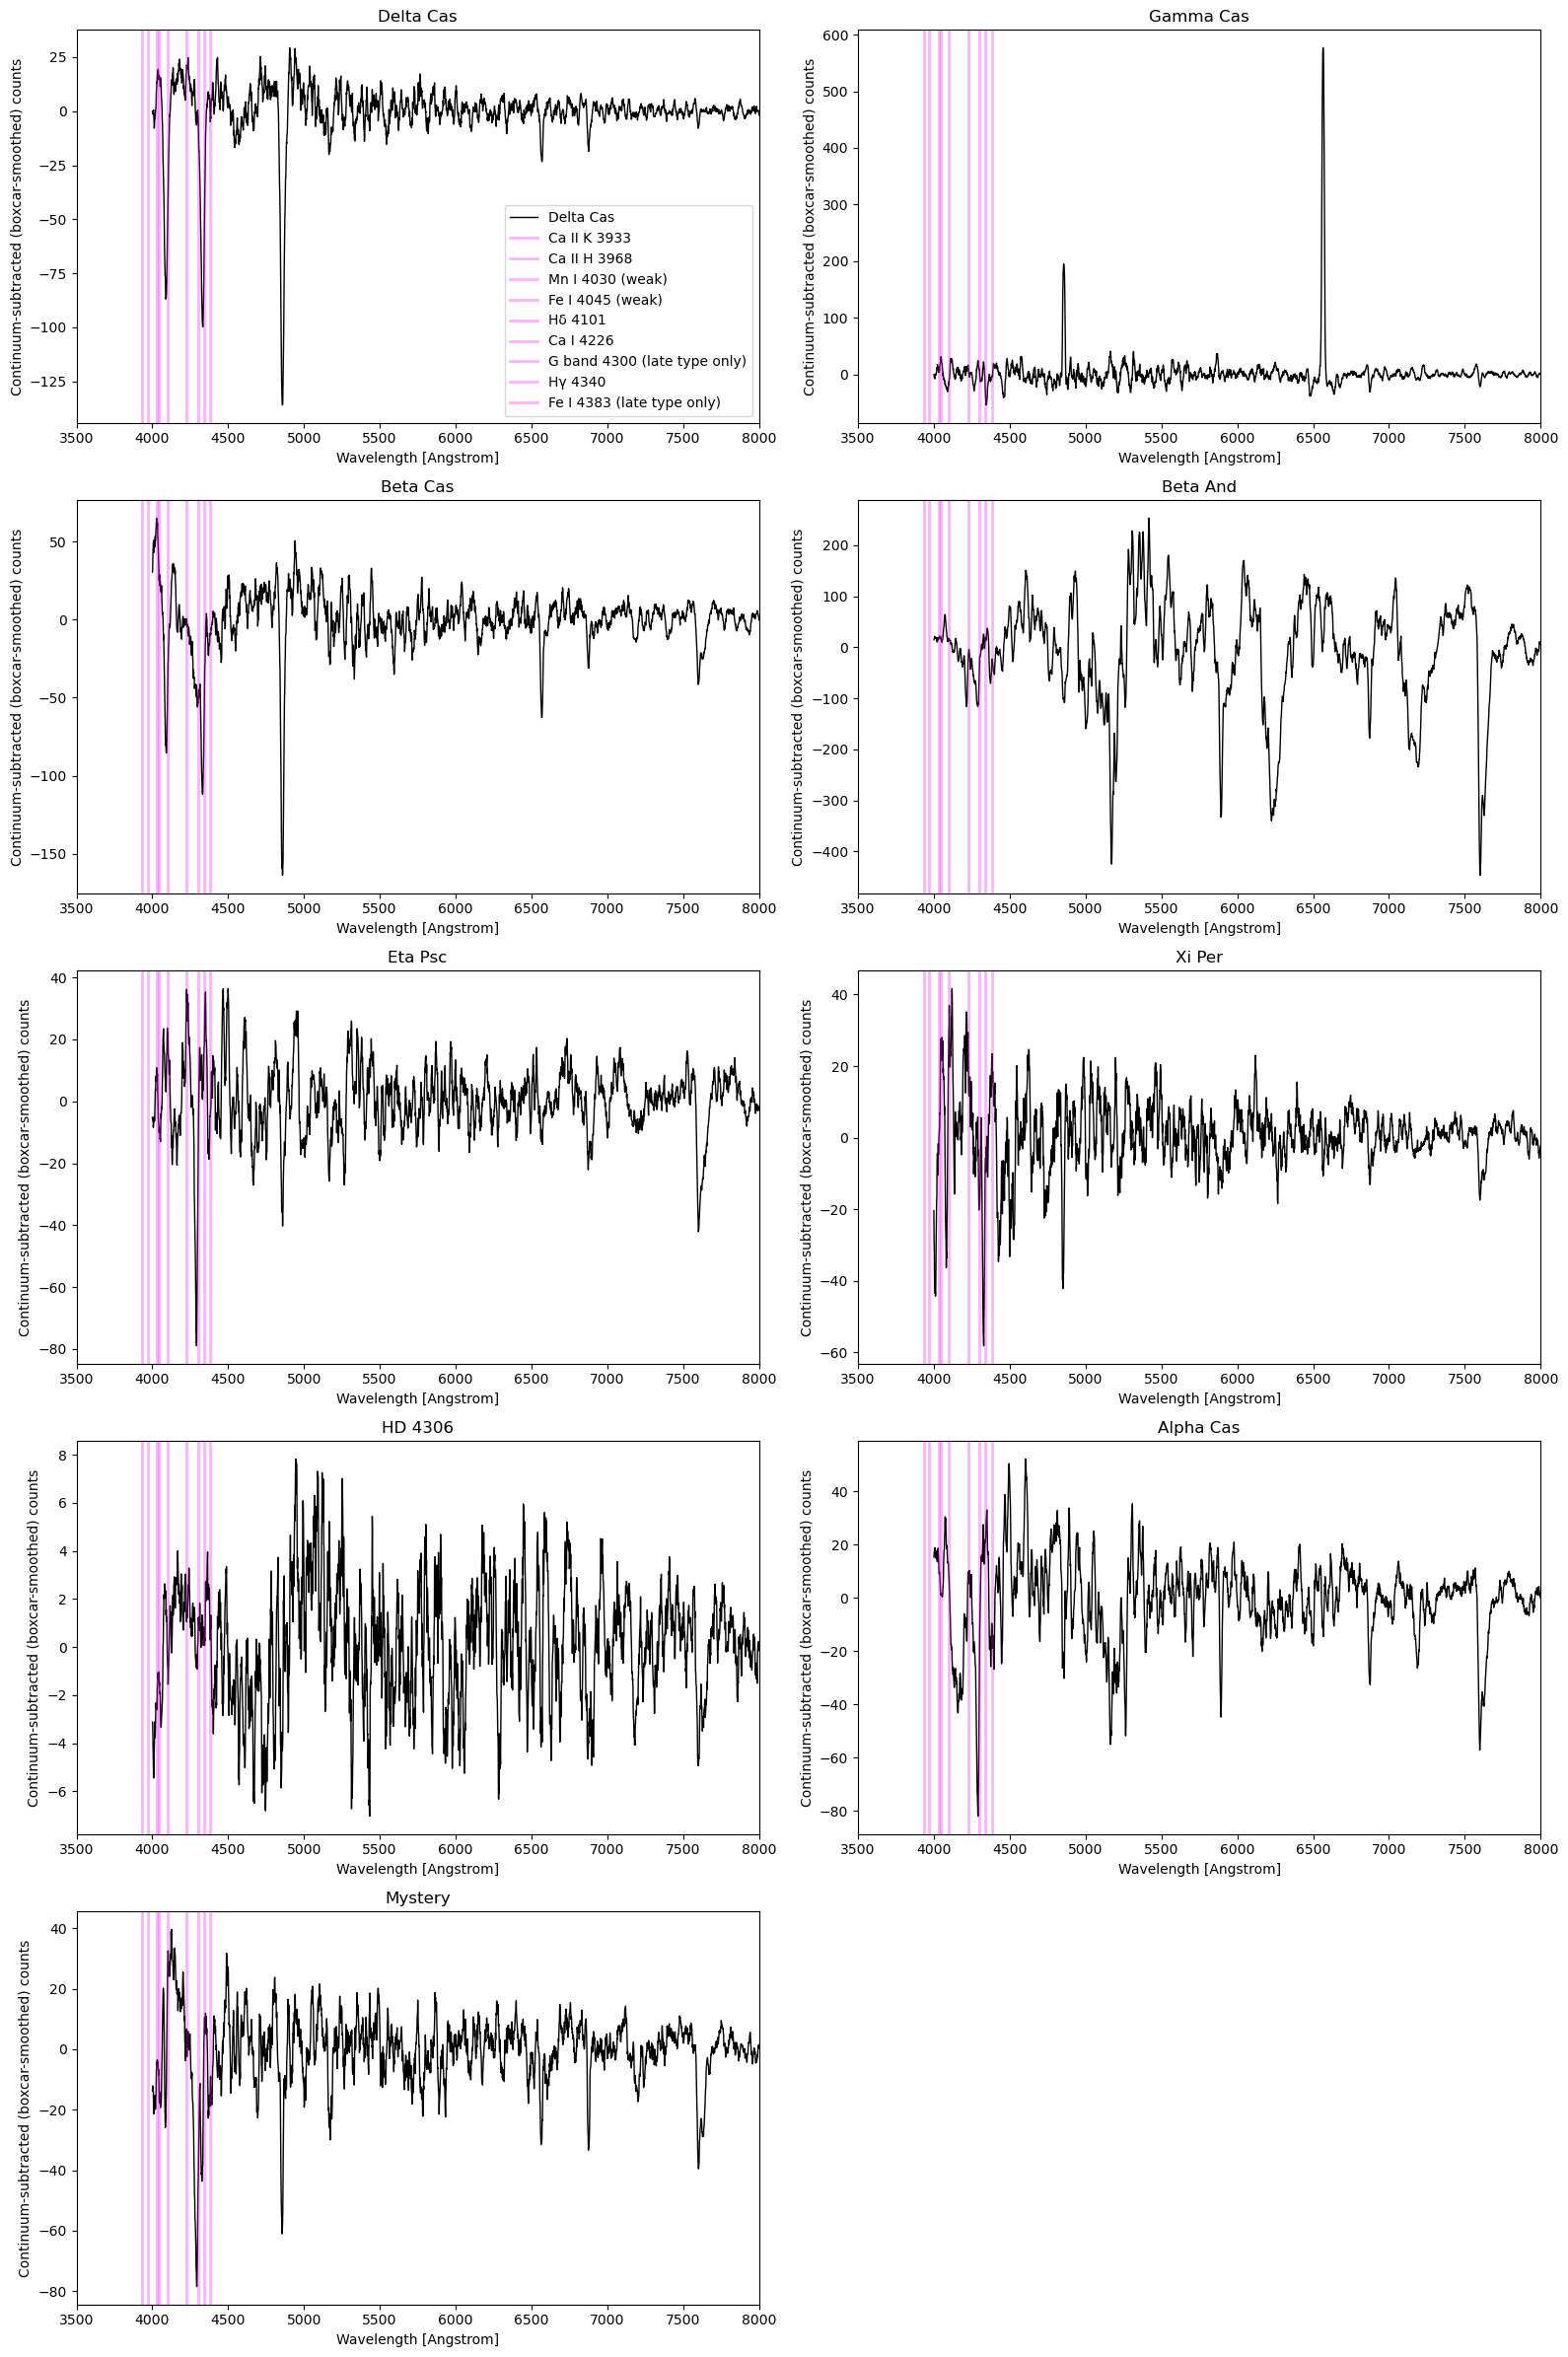

In [28]:
# ...existing code...

# --- Add F-type line labels ---
F_abs = np.array([3933, 3968, 4030, 4045, 4101, 4226, 4300, 4340, 4383])
F_abs_labels = {
    3933: "Ca II K 3933",
    3968: "Ca II H 3968",
    4030: "Mn I 4030 (weak)",
    4045: "Fe I 4045 (weak)",
    4101: "Hδ 4101",
    4226: "Ca I 4226",
    4300: "G band 4300 (late type only)",
    4340: "Hγ 4340",
    4383: "Fe I 4383 (late type only)"
}
wavelengths_of_interest_abs = list(F_abs_labels.keys())
wavelengths_of_interest_em = []

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4000) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)

    # Only add each label once to the legend (on the first subplot)
    shown_abs = set()
    for w in wavelengths_of_interest_abs:
        label = F_abs_labels[w] if (i == 0 and w not in shown_abs) else None
        plt.axvline(w, color='magenta', linestyle='-', alpha=0.3, lw=2, label=label)
        shown_abs.add(w)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# G type

In [29]:
G_abs = np.array([3933, 3968, 4045, 4101, 4226, 4300, 4325, 4340, 4383])


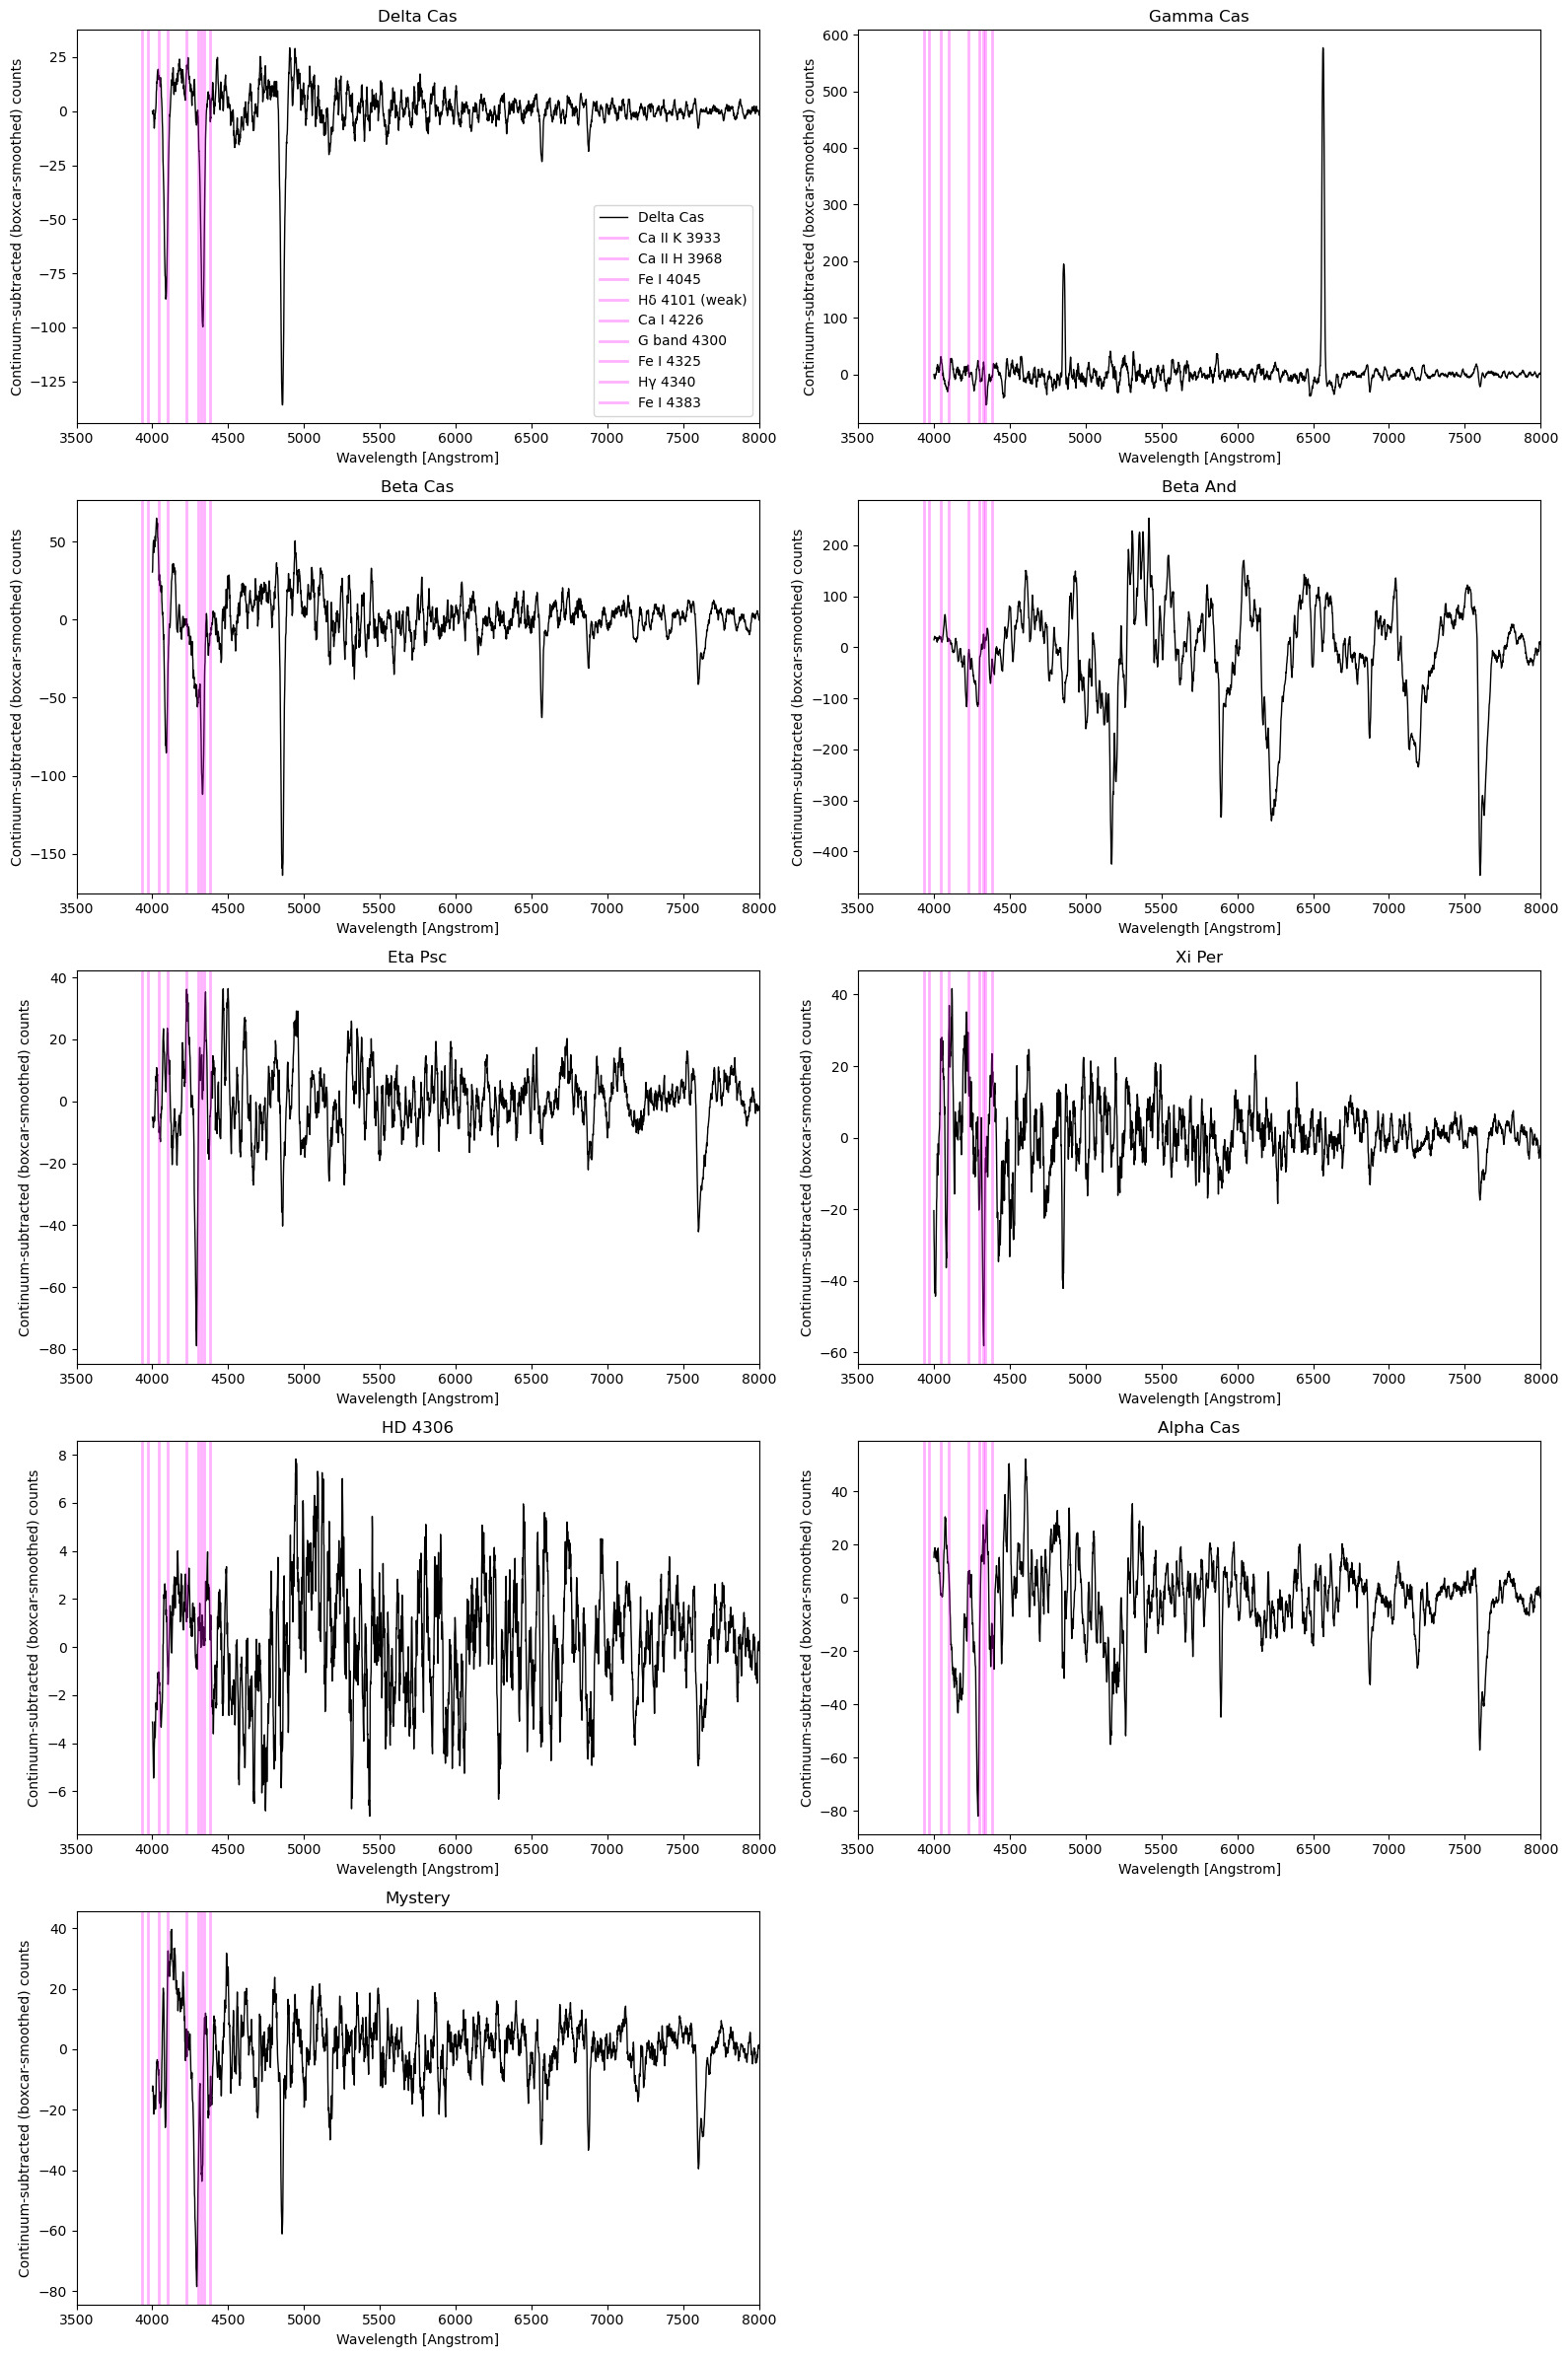

In [30]:
# ...existing code...

# --- Add G-type line labels ---
G_abs = np.array([3933, 3968, 4045, 4101, 4226, 4300, 4325, 4340, 4383])
G_abs_labels = {
    3933: "Ca II K 3933",
    3968: "Ca II H 3968",
    4045: "Fe I 4045",
    4101: "Hδ 4101 (weak)",
    4226: "Ca I 4226",
    4300: "G band 4300",
    4325: "Fe I 4325",
    4340: "Hγ 4340",
    4383: "Fe I 4383"
}
wavelengths_of_interest_abs = list(G_abs_labels.keys())
wavelengths_of_interest_em = []

plt.figure(figsize=(16, 24))
for i, obj in enumerate(obj_names):
    # Load and calibrate science and NeAr images
    imSci_full, _ = calibrate_science_frame(science_paths[i], master_bias, master_dark, master_flat)
    imSci = imSci_full[xmin:xmax, :]
    imNeAr_full, _ = calibrate_science_frame(near_cal_paths[i], master_bias, master_dark, master_flat)
    imNeAr = imNeAr_full[xmin:xmax, :]

    # Extract 1D spectra
    x_pix_sci, spec_sci = extract_1d_spec(imSci, ymins[i], ymaxs[i])
    xpix_NeAr, spec_1d_NeAr = extract_1d_spec(imNeAr, 1200, 1800)

    # Find NeAr peaks and fit wavelength solution
    strong_peaks_NeAr = my_find_peaks(spec_1d_NeAr, prominence=200, distance=10, num_peaks=7)
    m_wavecal_NeAr, b_wavecal_NeAr = linear_fit(strong_peaks_NeAr, wavelengths_NeAr)
    wl_sci_NeAr = m_wavecal_NeAr * x_pix_sci + b_wavecal_NeAr

    # Clip to wavelength range
    clip_mask = (wl_sci_NeAr >= 4000) & (wl_sci_NeAr <= 8000)
    wl_clip = wl_sci_NeAr[clip_mask]
    spec_clip = spec_sci[clip_mask]

    # --- CONTINUUM SUBTRACTION ---
    win1 = min(sg_windows_1[i], len(spec_clip)//2*2+1)
    cont_sg1 = savgol_filter(spec_clip, window_length=win1, polyorder=4)
    resid1 = spec_clip - cont_sg1
    sigma1 = np.std(resid1)
    mask1 = np.abs(resid1) < 1 * sigma1

    win2 = min(sg_windows_2[i], len(spec_clip[mask1])//2*2+1)
    cont_sg2_masked = savgol_filter(spec_clip[mask1], window_length=win2, polyorder=4)
    interp_cont_sg2 = interp1d(wl_clip[mask1], cont_sg2_masked, kind='linear', bounds_error=False, fill_value="extrapolate")
    cont_final = interp_cont_sg2(wl_clip)

    # Continuum-subtracted spectrum
    continuum_subtracted = spec_clip - cont_final

    # --- Apply boxcar smoothing to continuum-subtracted spectrum ---
    smoothed_spectrum = boxcar_smooth(continuum_subtracted, N=11)

    # Plot boxcar-smoothed, continuum-subtracted spectrum
    plt.subplot(5, 2, i+1)
    plt.plot(wl_clip, smoothed_spectrum, color='black', lw=1, label=obj)

    # Only add each label once to the legend (on the first subplot)
    shown_abs = set()
    for w in wavelengths_of_interest_abs:
        label = G_abs_labels[w] if (i == 0 and w not in shown_abs) else None
        plt.axvline(w, color='magenta', linestyle='-', alpha=0.3, lw=2, label=label)
        shown_abs.add(w)

    plt.title(obj)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Continuum-subtracted (boxcar-smoothed) counts')
    plt.xlim(3500, 8000)
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

# K type

In [31]:

K_abs = np.array([3933, 3970, 4101, 4226, 4250, 4300, 4340, 4761, 4780])
"""    
3933, 3970 get weaker toward late type
4101 WEAK
4761, 4780 late type only, WEAK
"""

'    \n3933, 3970 get weaker toward late type\n4101 WEAK\n4761, 4780 late type only, WEAK\n'

# M type 

In [32]:

M_all = np.array([4226, 4584, 4625, 4670, 4760, 4808, 4954])
"""    
4226 stronger towards later types
4584 to 4954 TiO
"""

'    \n4226 stronger towards later types\n4584 to 4954 TiO\n'